In [3]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install seaborn

## Configuración:
* Importación Librerias
* Definición rutas
* Definición funciones auxiliares

In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import numpy as np

# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import (
    confusion_matrix,              # ya lo estabas usando
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC
from utils import month_name_to_number, month_number_to_name
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

Versión de DGL: 2.5.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [2]:
# Fecha 
MES = "febrero"
ANO = "2024"

Primero se de debe correr notebook create_as_attr.ipynb el cual crea el archivo  node_feature_{MES}_{ANO}.csv"
correspondientet a los atributos de los nodos de una fecha especifica a partir de la informacion recolectada de PeeringDB para es afecha

In [3]:
# Path proyecto base
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# MAximo numero de rutas a procesar del RIB para crear grafo
MAX_NUM_ROUTES = 1000000 # None

### Funciones Auxiliares plot

In [4]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Matriz de confusión',
                          fname=None,
                          cmap=plt.cm.Blues,
                          save=False):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    
    if save and fname is not None:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_2(cm,
                            classes,
                            normalize=False,
                            title='Matriz de confusión',
                            fname=None,
                            cmap=plt.cm.Blues,
                            save=False):
    """
    Dibuja la matriz de confusión.
    Si `normalize=True`, muestra los valores en **porcentaje (%)**.
    """
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # → %
        print("Matriz de confusión normalizada (%)")
        fmt  = ".1f"   # un decimal
        suffix = "%"   # añade símbolo %
    else:
        print("Matriz de confusión sin normalizar")
        fmt  = "d"
        suffix = ""

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i,
                     f"{format(cm[i, j], fmt)}{suffix}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Etiqueta real")
    plt.xlabel("Etiqueta predicha")
    plt.tight_layout()

    # if save and fname:
        # plt.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    plt.show()

## Creacion Grafo 

Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream.

In [10]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt

/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt*


In [16]:
from modules.graph import create_graphs_from_ribs
# CASO 0,2,3: Grafo con atributos de nodos extraídos de PeeringDB
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "peeringdb")

# CASO 1: Grafo con atributos de grado de entrada y salida 
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "degree")

# CASO 4: Grafo con atributos de nodos generados aleatoriamente 
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "random")

[CARPETA CREADA]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/random/
[ARCHIVO META CREADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/random//meta.yaml

[CREANDO GRAFO MES]: enero---------------------------------
[SI EXISTE]
numero: 1
graph_id: 1
[NX GRAPH]: DiGraph with 41423 nodes and 148905 edges
[SAVE IN]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/random/edges.csv
[AGREGANDO FEATURES ALEATORIOS A NODOS (69 features)]
Creando archivo: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/random/nodes.csv
[ARCHIVO ACTUALIZADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/random/nodes.csv
[ATTRS ALEATORIOS CREADOS]: 41423 nodos con 69 features cada uno
[NX GRAPH]: DiGraph with 41423 nodes and 148905 edges
[GRAFO NX] DiGraph with 41423 nodes and 148905 edges

[CREANDO GRAFO MES]: febrero---------------------------------
[SI EXISTE]
numero: 2
graph_id: 2
[NX GRAPH]: DiGraph with 42242 nodes and 149763 edges
[SAVE IN]: /media/valentina/KINGSTON/TESIS/da

## Entrenamiento

In [5]:
# Fecha
# -------------------------------
ANO = "2024"
MES = "febrero"

# Ruta archivo CAIDA AS Relationships
# -------------------------------
RELATIONSHIPS_FILE  = DATA_PATH + f"CAIDA_AS_Relationships/Serial_1/{ANO}{month_name_to_number(MES)}01.as-rel.txt.bz2"

# Epochs
# -------------------------------
NUM_EPOCHS = 100

### Caso 0: Se utiliza grafo con atributos de nodos extraídos de PeeringDB 

In [ ]:
# CASO 0,2,3: Grafo con atributos de nodos extraídos de PeeringDB
# ---------------------------------------
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'

In [ ]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path= INTERNETGRAPH_FILE,
    index_graph=index_graph,            # grafo de febrero
    caida_path=RELATIONSHIPS_FILE,
    simplify=True, 
)
gnn.split_edges_classification(train_size=0.8, seed=42)


#### Caso 0.0: No Leaky split

In [21]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

##### Encoder : decodeBilinear


 Entrenamiento Training GCN (Bilinear) 
 -----------------
ep01  loss_tr 1.0880 acc_tr 69.11% | loss_te 2.8067 acc_te 68.56%
ep10  loss_tr 0.8948 acc_tr 68.46% | loss_te 0.8985 acc_te 68.56%
ep20  loss_tr 0.8095 acc_tr 68.66% | loss_te 0.7937 acc_te 68.56%
ep30  loss_tr 0.6768 acc_tr 68.73% | loss_te 0.6654 acc_te 68.86%
ep40  loss_tr 0.6223 acc_tr 69.61% | loss_te 0.6165 acc_te 69.97%
ep50  loss_tr 0.6037 acc_tr 71.19% | loss_te 0.6005 acc_te 71.53%
ep60  loss_tr 0.5790 acc_tr 71.39% | loss_te 0.5764 acc_te 71.47%
ep70  loss_tr 0.5550 acc_tr 71.72% | loss_te 0.5557 acc_te 71.69%
ep80  loss_tr 0.5531 acc_tr 73.94% | loss_te 0.5452 acc_te 73.98%
ep90  loss_tr 0.5436 acc_tr 76.69% | loss_te 0.5350 acc_te 77.06%
ep100  loss_tr 0.5459 acc_tr 76.26% | loss_te 0.5311 acc_te 77.40%
ep110  loss_tr 0.5316 acc_tr 78.18% | loss_te 0.5308 acc_te 77.56%
 [EARLY STOP EN EPOCH]: 113
Matriz de confusión sin normalizar


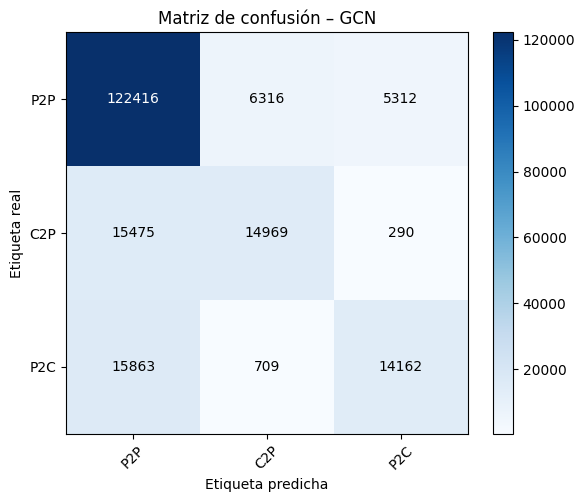

Matriz de confusión normalizada (%)


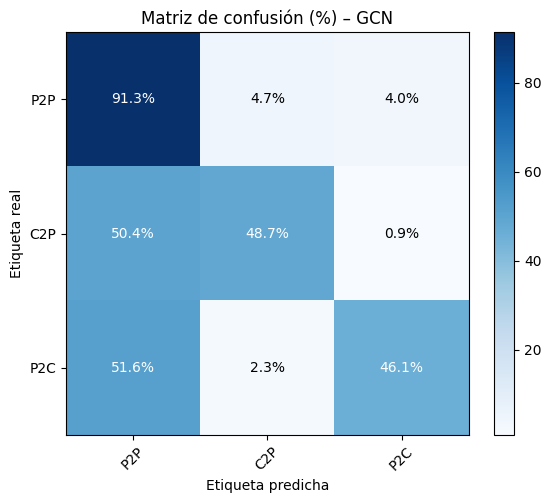

              precision    recall  f1-score   support

           0     0.7962    0.9133    0.8507    134044
           1     0.6806    0.4871    0.5678     30734
           2     0.7166    0.4608    0.5609     30734

    accuracy                         0.7751    195512
   macro avg     0.7311    0.6204    0.6598    195512
weighted avg     0.7655    0.7751    0.7607    195512

[TEST] micro:    Prec=77.51%  Rec=77.51%  F1=77.51% | Acc=77.51%
[TEST] macro:    Prec=73.11%  Rec=62.04%  F1=65.98%
[TEST] weighted: Prec=76.55%  Rec=77.51%  F1=76.07%


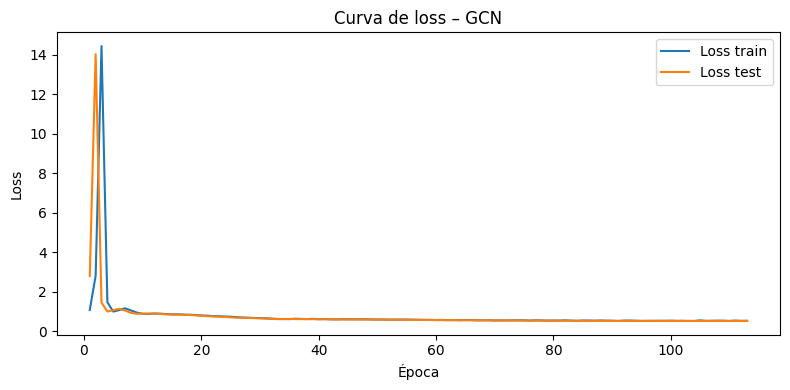

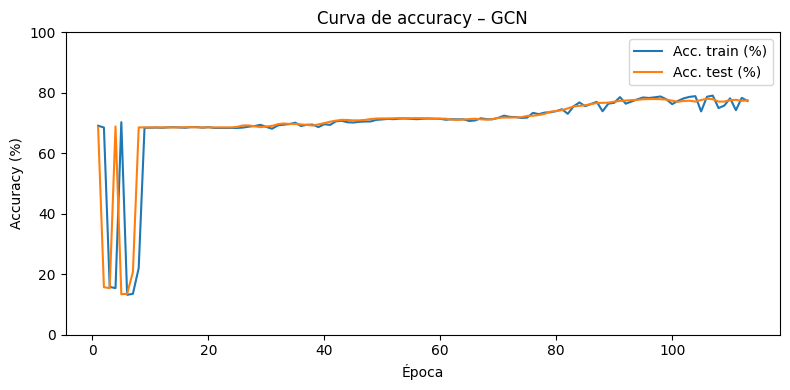

Archivo /media/valentina/KINGSTON/TESIS/resultados/inferencias_gnn/end_to_end/inference_results_GCN_febrero_caso0_mis_attr.txt guardado correctamente.

 Entrenamiento Training GraphSAGE (Bilinear) 
 -----------------
ep01  loss_tr 22.5740 acc_tr 26.76% | loss_te 38.0581 acc_te 66.90%
ep10  loss_tr 1.1034 acc_tr 62.12% | loss_te 1.0033 acc_te 55.08%
 [EARLY STOP EN EPOCH]: 18
Matriz de confusión sin normalizar


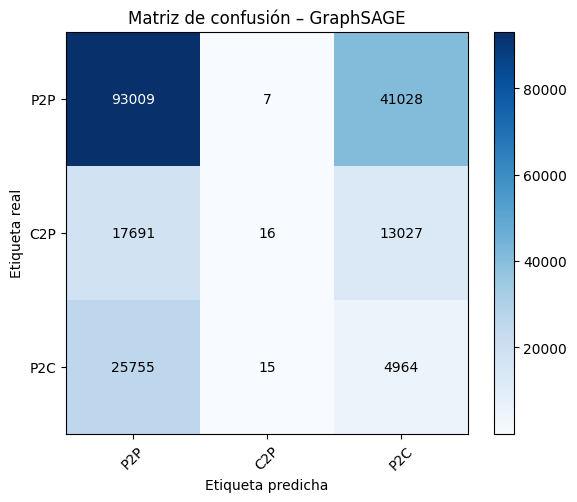

Matriz de confusión normalizada (%)


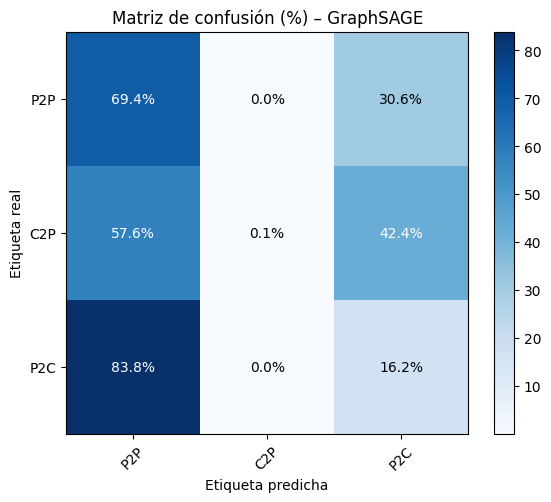

              precision    recall  f1-score   support

           0     0.6816    0.6939    0.6877    134044
           1     0.4211    0.0005    0.0010     30734
           2     0.0841    0.1615    0.1106     30734

    accuracy                         0.5012    195512
   macro avg     0.3956    0.2853    0.2664    195512
weighted avg     0.5467    0.5012    0.4890    195512

[TEST] micro:    Prec=50.12%  Rec=50.12%  F1=50.12% | Acc=50.12%
[TEST] macro:    Prec=39.56%  Rec=28.53%  F1=26.64%
[TEST] weighted: Prec=54.67%  Rec=50.12%  F1=48.90%


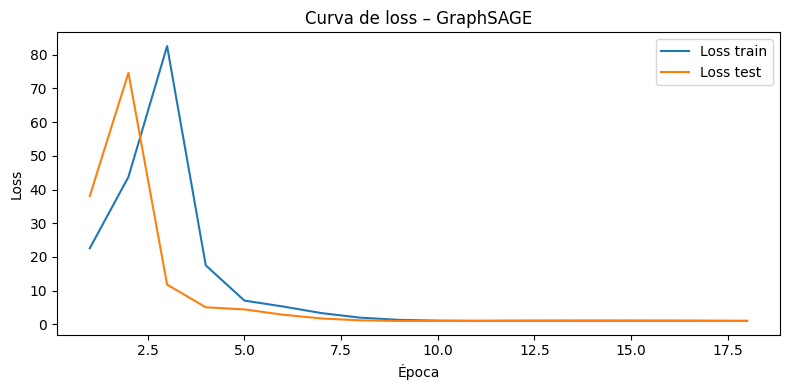

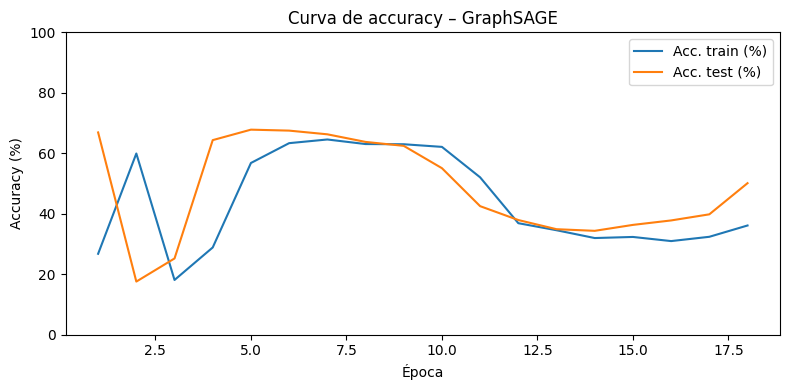

Archivo /media/valentina/KINGSTON/TESIS/resultados/inferencias_gnn/end_to_end/inference_results_GraphSAGE_febrero_caso0_mis_attr.txt guardado correctamente.

 Entrenamiento Training GAT (Bilinear) 
 -----------------
ep01  loss_tr 1.4192 acc_tr 68.94% | loss_te 1.2220 acc_te 18.14%
ep10  loss_tr 1.0268 acc_tr 70.01% | loss_te 0.9835 acc_te 69.22%
ep20  loss_tr 0.7656 acc_tr 71.37% | loss_te 0.7585 acc_te 72.36%
ep30  loss_tr 0.7217 acc_tr 74.34% | loss_te 0.7313 acc_te 74.65%
ep40  loss_tr 0.7098 acc_tr 75.25% | loss_te 0.7129 acc_te 75.52%
ep50  loss_tr 0.7021 acc_tr 75.18% | loss_te 0.7023 acc_te 75.55%
ep60  loss_tr 0.6943 acc_tr 75.39% | loss_te 0.6942 acc_te 75.63%
ep70  loss_tr 0.6885 acc_tr 75.47% | loss_te 0.6888 acc_te 75.45%
ep80  loss_tr 0.6858 acc_tr 75.75% | loss_te 0.6855 acc_te 75.51%
ep90  loss_tr 0.6815 acc_tr 76.00% | loss_te 0.6832 acc_te 75.68%
ep100  loss_tr 0.6762 acc_tr 76.22% | loss_te 0.6819 acc_te 75.69%
ep110  loss_tr 0.6692 acc_tr 76.51% | loss_te 0.6799 acc

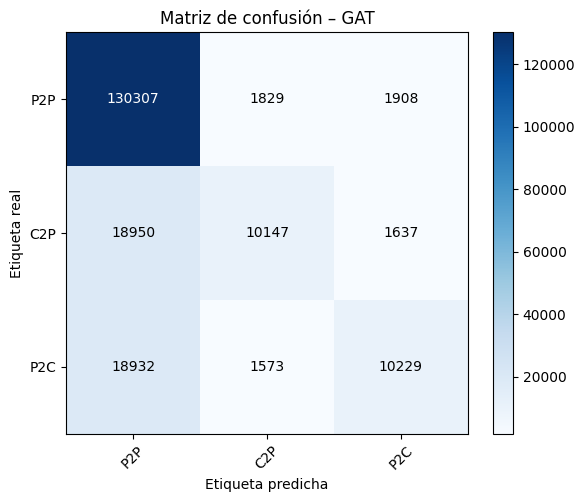

Matriz de confusión normalizada (%)


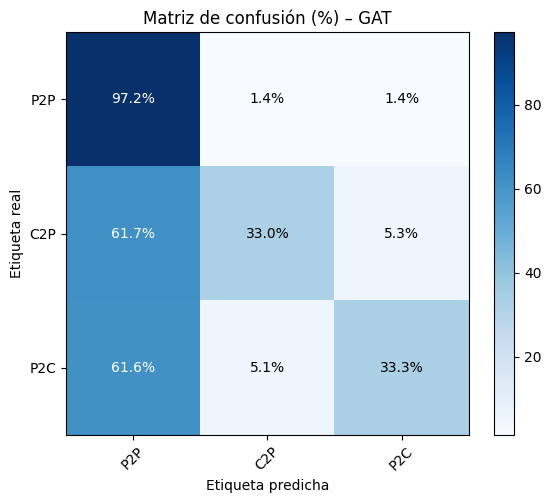

              precision    recall  f1-score   support

           0     0.7748    0.9721    0.8623    134044
           1     0.7489    0.3302    0.4583     30734
           2     0.7426    0.3328    0.4596     30734

    accuracy                         0.7707    195512
   macro avg     0.7554    0.5450    0.5934    195512
weighted avg     0.7656    0.7707    0.7355    195512

[TEST] micro:    Prec=77.07%  Rec=77.07%  F1=77.07% | Acc=77.07%
[TEST] macro:    Prec=75.54%  Rec=54.50%  F1=59.34%
[TEST] weighted: Prec=76.56%  Rec=77.07%  F1=73.55%


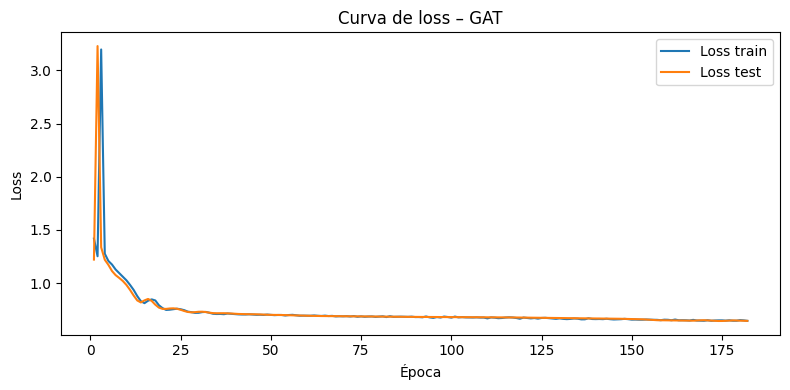

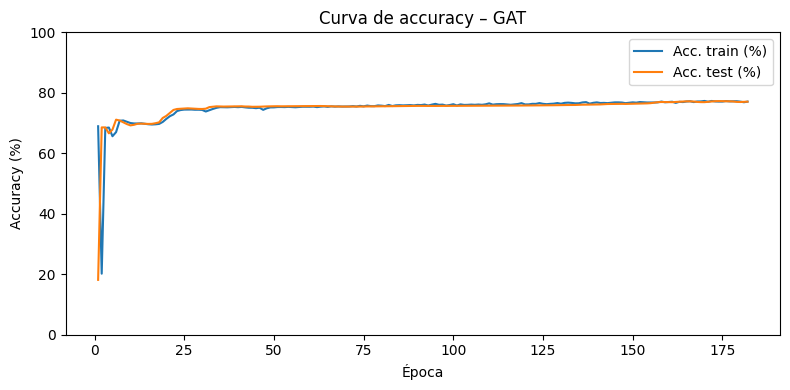

Archivo /media/valentina/KINGSTON/TESIS/resultados/inferencias_gnn/end_to_end/inference_results_GAT_febrero_caso0_mis_attr.txt guardado correctamente.


In [ ]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score
)
import seaborn as sns, matplotlib.pyplot as plt

# 1.- Definición parámetros
# --------------------------
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
lr            = 0.02
device        = "cuda" if torch.cuda.is_available() else "cpu"

# 2.- Datos y máscaras
# --------------------
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# 3.- Entrenamiento por modelo
# ----------------------------
for name, Model in models.items():
    print(f"\n Entrenamiento Training {name} (Bilinear) \n -----------------")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, NUM_EPOCHS + 1):
        # Entrenamiento por epoch
        # -----------------------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # Test 
        # ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()

        # Guardar valores históricos
        # -----------------------
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # Early stopping
        # ------------------------
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f" [EARLY STOP EN EPOCH]: {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # Matriz de confusión final 
    # --------------------------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))










# ─── métricas micro / macro / weighted y accuracy (en %) ─────────
    prec_micro = precision_score(truth, preds_best, average="micro") * 100
    rec_micro  = recall_score(truth, preds_best, average="micro") * 100
    f1_micro   = f1_score(truth, preds_best, average="micro") * 100
    acc        = accuracy_score(truth, preds_best) * 100

    prec_macro = precision_score(truth, preds_best, average="macro") * 100
    rec_macro  = recall_score(truth, preds_best, average="macro") * 100
    f1_macro   = f1_score(truth, preds_best, average="macro") * 100

    prec_w     = precision_score(truth, preds_best, average="weighted") * 100
    rec_w      = recall_score(truth, preds_best, average="weighted") * 100
    f1_w       = f1_score(truth, preds_best, average="weighted") * 100

    print(f"[TEST] micro:    Prec={prec_micro:.2f}%  Rec={rec_micro:.2f}%  F1={f1_micro:.2f}% | Acc={acc:.2f}%")
    print(f"[TEST] macro:    Prec={prec_macro:.2f}%  Rec={rec_macro:.2f}%  F1={f1_macro:.2f}%")
    print(f"[TEST] weighted: Prec={prec_w:.2f}%  Rec={rec_w:.2f}%  F1={f1_w:.2f}%")




















    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.savefig( '/media/valentina/KINGSTON/TESIS/resultados/graficos/end-to-end/' + f"loss_{name}_caso0_mis_attr.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.savefig( '/media/valentina/KINGSTON/TESIS/resultados/graficos/end-to-end/' + f"accuracy_{name}_caso0_mis_attr.png", dpi=300, bbox_inches='tight')
    plt.show()


    out_file = f"/media/valentina/KINGSTON/TESIS/resultados/inferencias_gnn/end_to_end/inference_results_{name}_{MES}_caso0_mis_attr.txt"
    u, v = g.edges()
    with open(out_file, "w") as f:
        for i, eidx in enumerate(torch.nonzero(test_m, as_tuple=False).squeeze().cpu().numpy()):
            as1 = int(u[eidx].item())
            as2 = int(v[eidx].item())
            pred = int(preds_best[i].item())
            real = int(truth[i].item())
            f.write(f"{as1}|{as2}|{pred}|{real}\n")

    print(f"Archivo {out_file} guardado correctamente.")


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


# 6 min


In [ ]:
best_loss = float('inf')
best_ep   = 0
best_w    = None           # se llenará con los pesos óptimos

for epoch in range(1, NUM_EPOCHS + 1):
    # ----- train -----
    model.train()
    h      = model.encode(g, feat)
    logits = model.decodeBilinear(g, h)
    loss   = F.cross_entropy(logits[train_m], labels[train_m])

    opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        preds_tr = logits[train_m].argmax(1)
        acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

    # ----- test -----
    model.eval()
    with torch.no_grad():
        logits_te = model.decodeBilinear(g, model.encode(g, feat))
        loss_te   = F.cross_entropy(logits_te[test_m], labels[test_m])
        preds_te  = logits_te[test_m].argmax(1)
        acc_te    = (preds_te == labels[test_m]).float().mean().item()

    # Guarda valores histórico 
    # ----------------------
    history["loss_tr"].append(loss.item())
    history["loss_te"].append(loss_te.item())
    history["acc_tr"].append(acc_tr * 100)
    history["acc_te"].append(acc_te * 100)

    # Guardar el mejor modelo
    # ----------------------
    if loss_te < best_loss - 1e-4:
        best_loss = loss_te
        best_ep   = epoch
        best_w    = model.state_dict()  # copia profunda de los pesos

    if epoch % 10 == 0 or epoch == 1:
        print(f"ep{epoch:03d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
              f"loss_te {loss_te:.4f} acc_te {acc_te:.2%}")

print(f"\nMejor epoch: {best_ep}  –  loss_te = {best_loss:.4f}")
model.load_state_dict(best_w)  # ← se restauran los pesos óptimos

# 4 min 

ep001  loss_tr 0.6481 acc_tr 77.05% | loss_te 0.6451 acc_te 77.12%
ep010  loss_tr 0.6468 acc_tr 77.25% | loss_te 0.6423 acc_te 77.25%
ep020  loss_tr 0.6436 acc_tr 77.35% | loss_te 0.6407 acc_te 77.41%
ep030  loss_tr 0.6331 acc_tr 77.62% | loss_te 0.6336 acc_te 77.74%
ep040  loss_tr 0.6201 acc_tr 77.85% | loss_te 0.6155 acc_te 78.14%
ep050  loss_tr 0.5948 acc_tr 78.61% | loss_te 0.5798 acc_te 78.28%
ep060  loss_tr 0.6092 acc_tr 79.47% | loss_te 0.5708 acc_te 78.10%
ep070  loss_tr 0.5991 acc_tr 77.94% | loss_te 0.5734 acc_te 78.22%
ep080  loss_tr 0.5699 acc_tr 79.49% | loss_te 0.5786 acc_te 80.35%
ep090  loss_tr 0.6019 acc_tr 80.95% | loss_te 0.5622 acc_te 78.72%
ep100  loss_tr 0.5586 acc_tr 79.90% | loss_te 0.5439 acc_te 79.17%
ep110  loss_tr 0.5790 acc_tr 78.57% | loss_te 0.5467 acc_te 79.23%
ep120  loss_tr 0.5820 acc_tr 78.65% | loss_te 0.5317 acc_te 80.19%
ep130  loss_tr 0.5536 acc_tr 80.14% | loss_te 0.5312 acc_te 81.06%
ep140  loss_tr 0.5446 acc_tr 80.56% | loss_te 0.5361 acc_te 81

<All keys matched successfully>

##### Encoder : MLP


=== Training GCN ===
ep01 | loss_tr 1.0910 acc_tr 17.86% | loss_te 0.9074 acc_te 69.70%
ep10 | loss_tr 0.5831 acc_tr 69.68% | loss_te 0.5941 acc_te 69.70%
ep20 | loss_tr 0.5609 acc_tr 71.57% | loss_te 0.5749 acc_te 70.71%
ep30 | loss_tr 0.5526 acc_tr 72.45% | loss_te 0.5422 acc_te 73.33%
ep40 | loss_tr 0.5080 acc_tr 77.63% | loss_te 0.5005 acc_te 78.11%
ep50 | loss_tr 0.4890 acc_tr 79.55% | loss_te 0.4873 acc_te 80.66%
ep60 | loss_tr 0.4893 acc_tr 81.69% | loss_te 0.4373 acc_te 83.59%
ep70 | loss_tr 0.4824 acc_tr 81.17% | loss_te 0.4102 acc_te 85.27%
ep80 | loss_tr 0.4111 acc_tr 84.90% | loss_te 0.3870 acc_te 86.08%
ep90 | loss_tr 0.3877 acc_tr 85.68% | loss_te 0.3821 acc_te 85.82%
ep100 | loss_tr 0.3720 acc_tr 86.45% | loss_te 0.3692 acc_te 86.29%
ep110 | loss_tr 0.3545 acc_tr 86.92% | loss_te 0.3603 acc_te 86.37%
ep120 | loss_tr 0.3590 acc_tr 86.69% | loss_te 0.3525 acc_te 86.57%
ep130 | loss_tr 0.3577 acc_tr 86.46% | loss_te 0.3477 acc_te 86.77%
ep140 | loss_tr 0.3560 acc_tr 86.35%

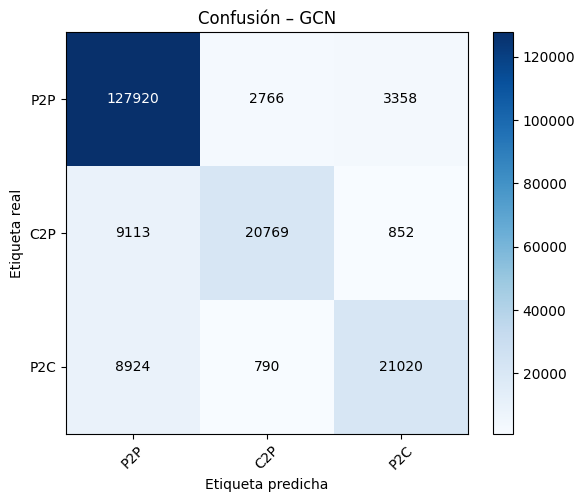

Matriz de confusión normalizada (%)


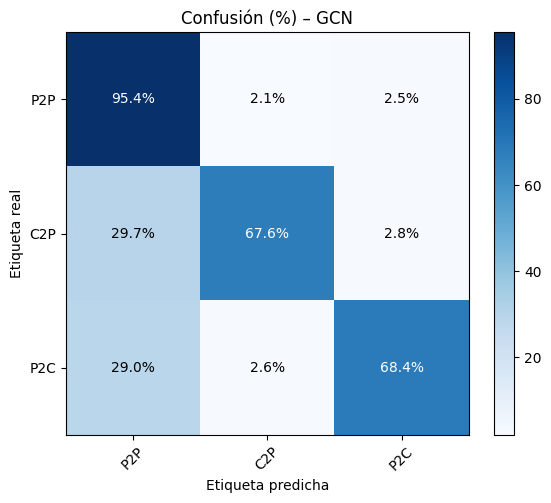

              precision    recall  f1-score   support

           0     0.8764    0.9543    0.9137    134044
           1     0.8538    0.6758    0.7544     30734
           2     0.8331    0.6839    0.7512     30734

    accuracy                         0.8680    195512
   macro avg     0.8545    0.7713    0.8064    195512
weighted avg     0.8661    0.8680    0.8631    195512



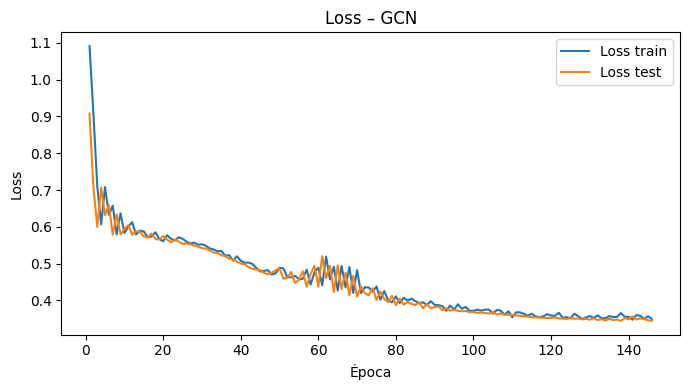

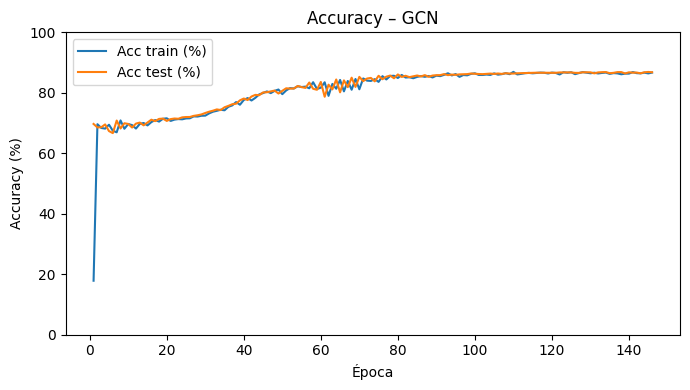


=== Training GraphSAGE ===
ep01 | loss_tr 1.0389 acc_tr 60.35% | loss_te 1.3054 acc_te 68.56%
ep10 | loss_tr 0.7791 acc_tr 68.88% | loss_te 0.7314 acc_te 69.88%
ep20 | loss_tr 0.6664 acc_tr 72.74% | loss_te 0.6470 acc_te 74.19%
ep30 | loss_tr 0.5781 acc_tr 81.36% | loss_te 0.5712 acc_te 81.79%
ep40 | loss_tr 0.5507 acc_tr 81.63% | loss_te 0.5399 acc_te 81.89%
ep50 | loss_tr 0.5176 acc_tr 82.20% | loss_te 0.5031 acc_te 82.20%
ep60 | loss_tr 0.4973 acc_tr 82.44% | loss_te 0.4851 acc_te 82.55%
ep70 | loss_tr 0.4795 acc_tr 83.39% | loss_te 0.5028 acc_te 83.22%
🛑  Early stop en época 74
Matriz de confusión sin normalizar


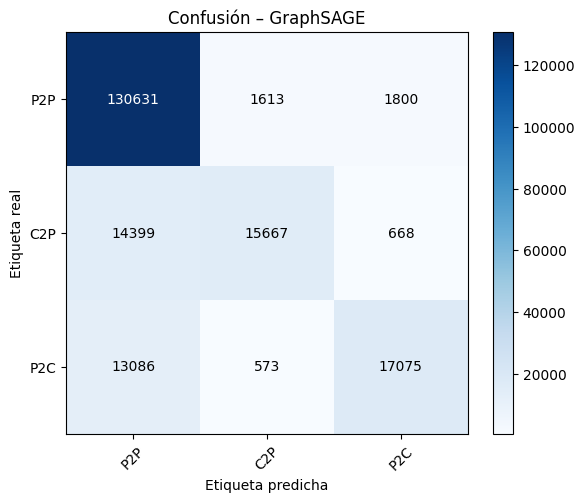

Matriz de confusión normalizada (%)


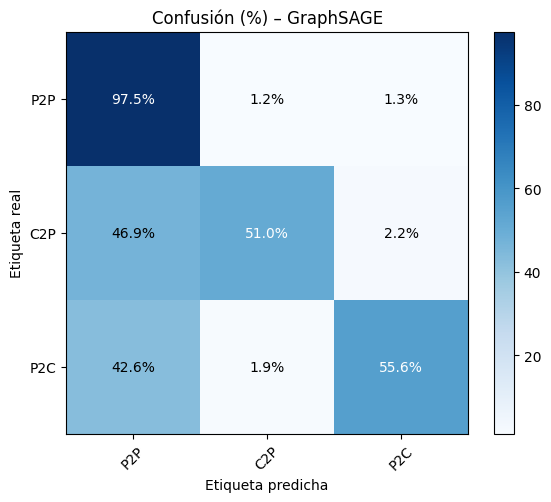

              precision    recall  f1-score   support

           0     0.8262    0.9745    0.8942    134044
           1     0.8776    0.5098    0.6449     30734
           2     0.8737    0.5556    0.6792     30734

    accuracy                         0.8356    195512
   macro avg     0.8591    0.6800    0.7395    195512
weighted avg     0.8417    0.8356    0.8212    195512



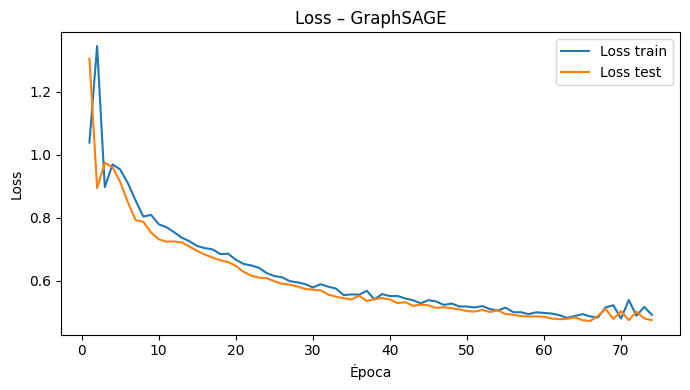

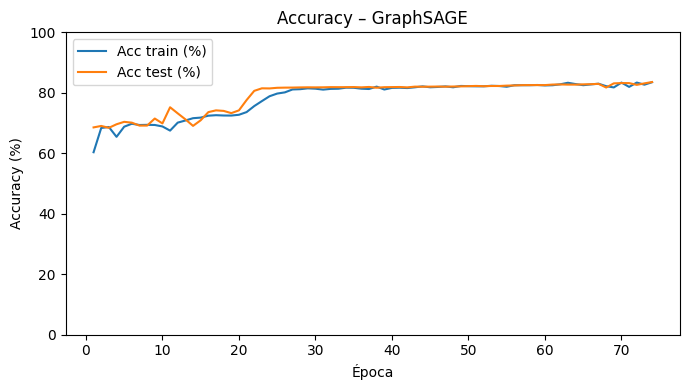


=== Training GAT ===
ep01 | loss_tr 1.1279 acc_tr 16.40% | loss_te 1.0563 acc_te 39.64%
ep10 | loss_tr 0.7883 acc_tr 68.41% | loss_te 0.8914 acc_te 68.56%
🛑  Early stop en época 14
Matriz de confusión sin normalizar


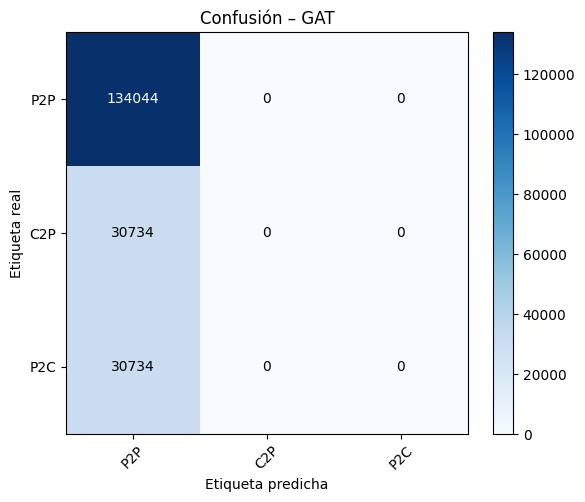

Matriz de confusión normalizada (%)


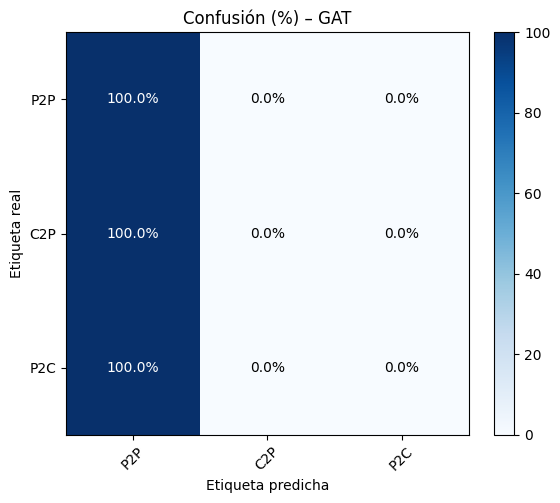

              precision    recall  f1-score   support

           0     0.6856    1.0000    0.8135    134044
           1     0.0000    0.0000    0.0000     30734
           2     0.0000    0.0000    0.0000     30734

    accuracy                         0.6856    195512
   macro avg     0.2285    0.3333    0.2712    195512
weighted avg     0.4701    0.6856    0.5577    195512



/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

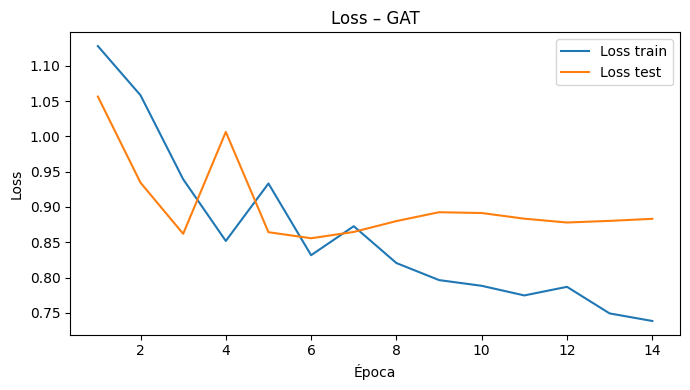

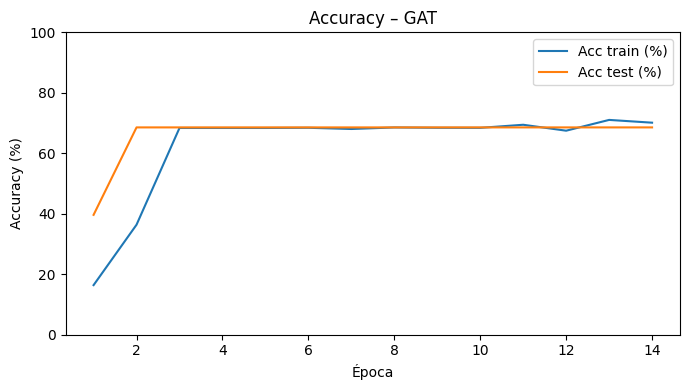

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
lr        = 0.02
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, NUM_EPOCHS + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

# 4 m in

In [37]:


for split, m in zip(["train", "test"], [train_m, test_m]):
    num = int(m.sum())
    clases = torch.bincount(labels[m], minlength=3).tolist()
    print(f"{split:<5}: {num:>7}  →  P2P={clases[0]}  C2P={clases[1]}  P2C={clases[2]}")



train:  782042  →  P2P=534688  C2P=123677  P2C=123677
test :  195512  →  P2P=134044  C2P=30734  P2C=30734


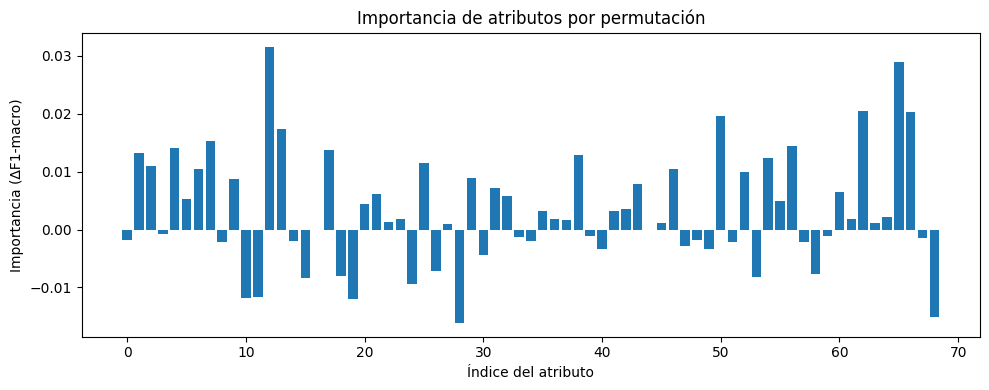

In [ ]:
import numpy as np
from copy import deepcopy
from sklearn.metrics import f1_score

def permutation_importance(model, g, features, labels, test_mask, metric=f1_score):
    model.eval()
    base_logits = model.decodeBilinear(g, model.encode(g, features))
    base_preds = base_logits[test_mask].argmax(dim=1).cpu()
    base_score = metric(labels[test_mask].cpu(), base_preds, average='macro')

    importances = []
    for i in range(features.shape[1]):
        features_shuffled = features.clone()
        perm = torch.randperm(features.shape[0])
        features_shuffled[:, i] = features_shuffled[perm, i]

        logits = model.decodeBilinear(g, model.encode(g, features_shuffled))
        preds = logits[test_mask].argmax(dim=1).cpu()
        score = metric(labels[test_mask].cpu(), preds, average='macro')
        delta = base_score - score
        importances.append(delta)

    return importances
import matplotlib.pyplot as plt

importances = permutation_importance(model, g, feat, labels, test_m)

plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances)
plt.xlabel("Índice del atributo")
plt.ylabel("Importancia (∆F1-macro)")
plt.title("Importancia de atributos por permutación")
plt.tight_layout()
plt.show()


#### Caso 0.1 : Leaky split

En este caso el split si es leaky, es decir ambas aritas de un mismo par de nodos pueden estar separadas en el split quedar una en el test y otro en train.

In [38]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

Encoder: Bilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.9068 acc_tr 68.61% | loss_te 3.6111 acc_te 16.27%
ep10  loss_tr 1.0687 acc_tr 70.64% | loss_te 0.9227 acc_te 71.60%
ep20  loss_tr 0.8773 acc_tr 68.93% | loss_te 0.8627 acc_te 68.69%
ep30  loss_tr 0.7248 acc_tr 64.74% | loss_te 0.7150 acc_te 61.64%
ep40  loss_tr 0.6565 acc_tr 68.37% | loss_te 0.6503 acc_te 68.51%
ep50  loss_tr 0.6011 acc_tr 69.79% | loss_te 0.5929 acc_te 70.57%
ep60  loss_tr 0.5844 acc_tr 70.96% | loss_te 0.5829 acc_te 71.01%
ep70  loss_tr 0.5641 acc_tr 71.46% | loss_te 0.5564 acc_te 71.71%
ep80  loss_tr 0.5463 acc_tr 72.13% | loss_te 0.5405 acc_te 72.42%
ep90  loss_tr 0.5272 acc_tr 73.11% | loss_te 0.5225 acc_te 73.23%
ep100  loss_tr 0.5192 acc_tr 75.22% | loss_te 0.5127 acc_te 75.12%
ep110  loss_tr 0.5530 acc_tr 76.08% | loss_te 0.5024 acc_te 78.02%
ep120  loss_tr 0.5058 acc_tr 79.46% | loss_te 0.5032 acc_te 78.64%
🛑  Early stop en epoch 129
Matriz de confusión sin normalizar


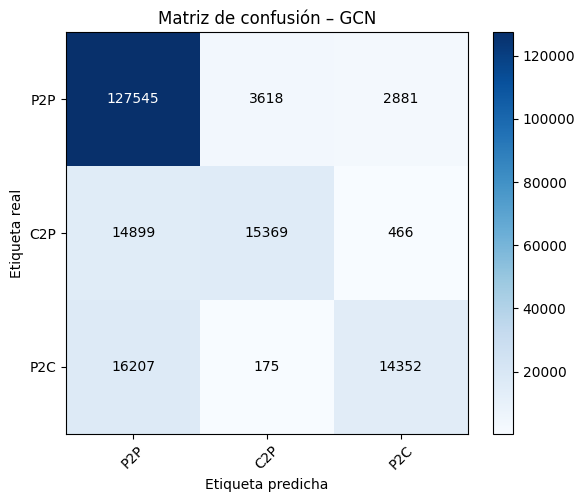

Matriz de confusión normalizada (%)


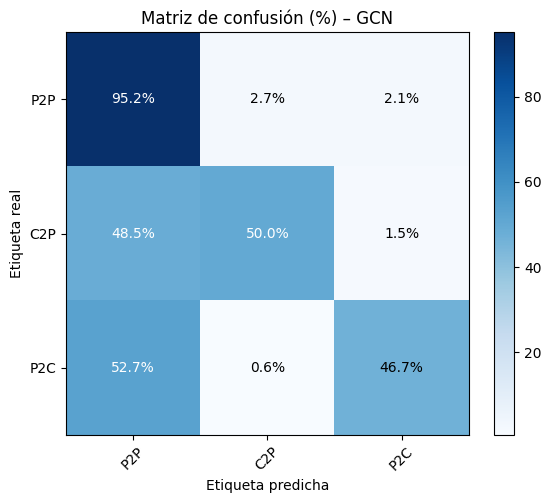

              precision    recall  f1-score   support

           0     0.8039    0.9515    0.8715    134044
           1     0.8021    0.5001    0.6160     30734
           2     0.8109    0.4670    0.5927     30734

    accuracy                         0.8044    195512
   macro avg     0.8056    0.6395    0.6934    195512
weighted avg     0.8047    0.8044    0.7875    195512



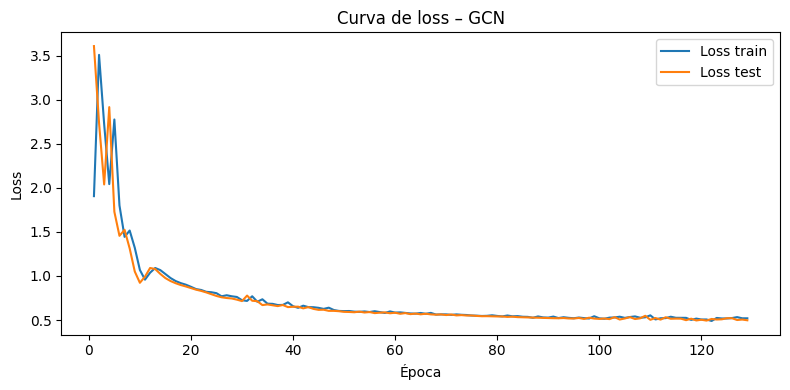

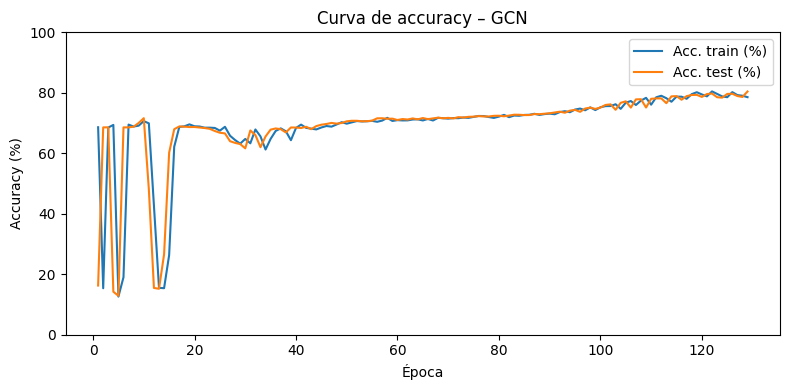


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 21.3399 acc_tr 25.86% | loss_te 8.1797 acc_te 36.73%
ep10  loss_tr 1.1173 acc_tr 56.15% | loss_te 0.9515 acc_te 61.53%
ep20  loss_tr 0.8868 acc_tr 68.44% | loss_te 0.8759 acc_te 68.63%
ep30  loss_tr 0.8317 acc_tr 68.41% | loss_te 0.8233 acc_te 68.59%
ep40  loss_tr 0.8135 acc_tr 68.47% | loss_te 0.8036 acc_te 68.64%
ep50  loss_tr 0.7791 acc_tr 69.42% | loss_te 0.7643 acc_te 69.38%
ep60  loss_tr 0.7650 acc_tr 72.36% | loss_te 0.7337 acc_te 72.31%
ep70  loss_tr 0.7477 acc_tr 72.16% | loss_te 0.7242 acc_te 71.46%
ep80  loss_tr 0.7327 acc_tr 71.57% | loss_te 0.7156 acc_te 71.11%
ep90  loss_tr 0.7194 acc_tr 72.54% | loss_te 0.6970 acc_te 72.65%
ep100  loss_tr 0.7191 acc_tr 72.42% | loss_te 0.6815 acc_te 73.12%
ep110  loss_tr 0.6828 acc_tr 72.89% | loss_te 0.6643 acc_te 73.76%
ep120  loss_tr 0.6752 acc_tr 73.53% | loss_te 0.6467 acc_te 74.81%
ep130  loss_tr 0.6321 acc_tr 78.50% | loss_te 0.6303 acc_te 78.24%
ep140  loss_tr 0.6050 acc_tr 81.

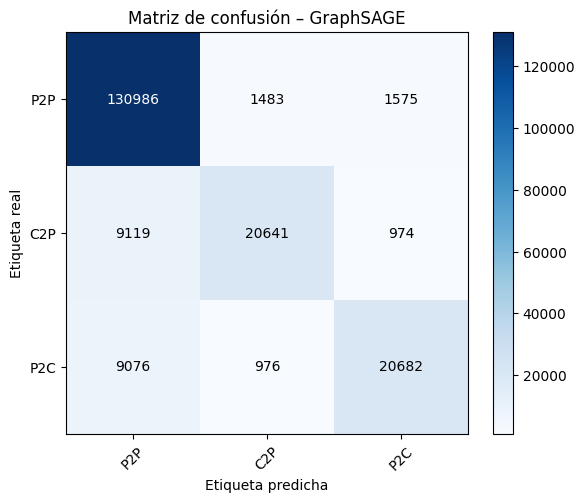

Matriz de confusión normalizada (%)


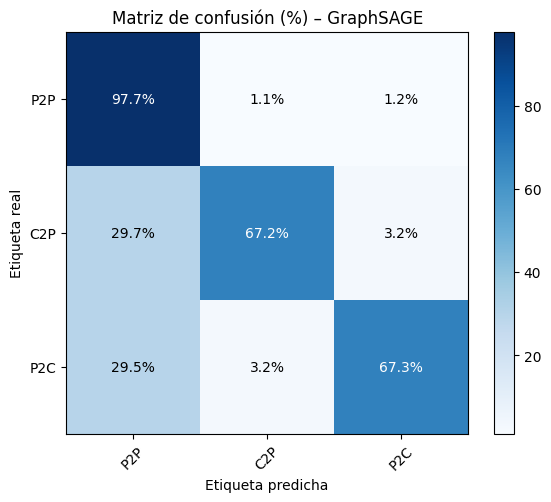

              precision    recall  f1-score   support

           0     0.8780    0.9772    0.9250    134044
           1     0.8935    0.6716    0.7668     30734
           2     0.8903    0.6729    0.7665     30734

    accuracy                         0.8813    195512
   macro avg     0.8873    0.7739    0.8194    195512
weighted avg     0.8824    0.8813    0.8752    195512



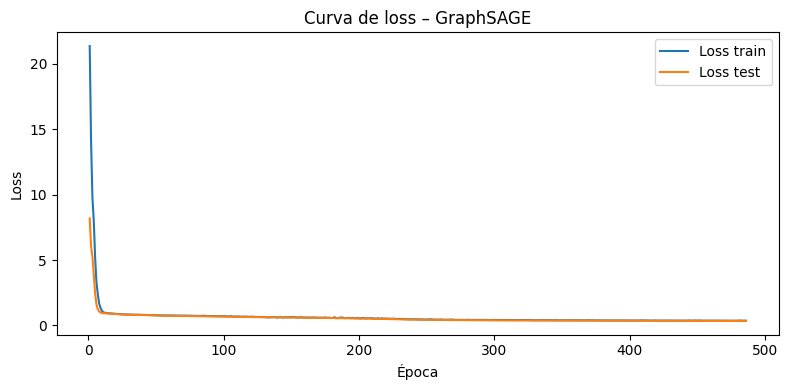

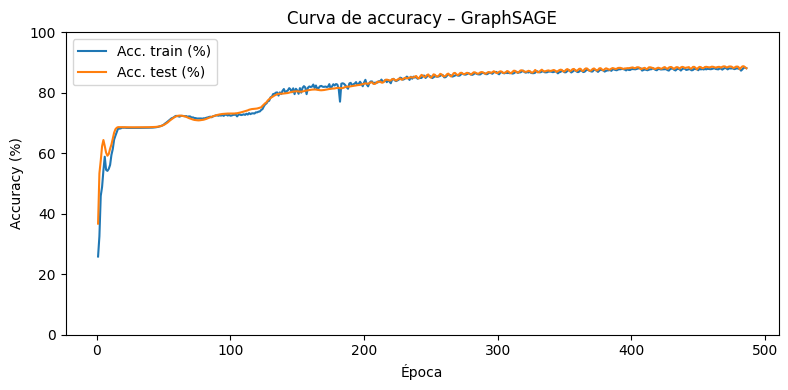


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1665 acc_tr 68.70% | loss_te 1.1154 acc_te 15.66%
ep10  loss_tr 0.8943 acc_tr 68.54% | loss_te 0.8756 acc_te 68.75%
ep20  loss_tr 0.7327 acc_tr 73.07% | loss_te 0.7029 acc_te 73.31%
ep30  loss_tr 0.6931 acc_tr 73.31% | loss_te 0.6749 acc_te 74.63%
ep40  loss_tr 0.6500 acc_tr 74.91% | loss_te 0.6315 acc_te 75.78%
ep50  loss_tr 0.6124 acc_tr 76.90% | loss_te 0.5937 acc_te 77.13%
ep60  loss_tr 0.5866 acc_tr 78.32% | loss_te 0.5618 acc_te 78.28%
ep70  loss_tr 0.5478 acc_tr 79.40% | loss_te 0.5345 acc_te 80.52%
ep80  loss_tr 0.5535 acc_tr 78.28% | loss_te 0.5083 acc_te 80.64%
ep90  loss_tr 0.5069 acc_tr 80.50% | loss_te 0.4985 acc_te 81.50%
ep100  loss_tr 0.4967 acc_tr 81.98% | loss_te 0.4667 acc_te 82.32%
ep110  loss_tr 0.4894 acc_tr 81.15% | loss_te 0.4902 acc_te 80.95%
🛑  Early stop en epoch 115
Matriz de confusión sin normalizar


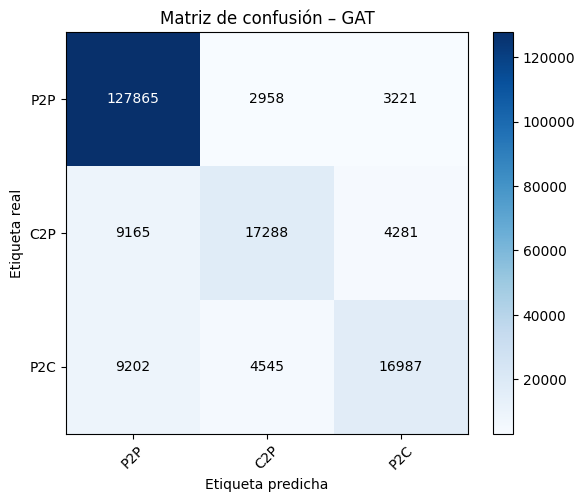

Matriz de confusión normalizada (%)


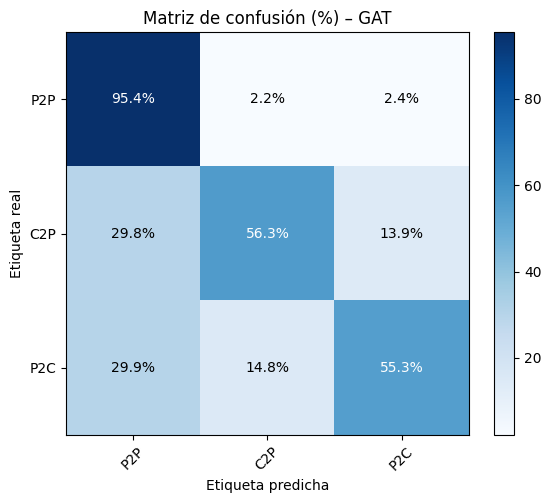

              precision    recall  f1-score   support

           0     0.8744    0.9539    0.9124    134044
           1     0.6973    0.5625    0.6227     30734
           2     0.6937    0.5527    0.6152     30734

    accuracy                         0.8293    195512
   macro avg     0.7551    0.6897    0.7168    195512
weighted avg     0.8182    0.8293    0.8202    195512



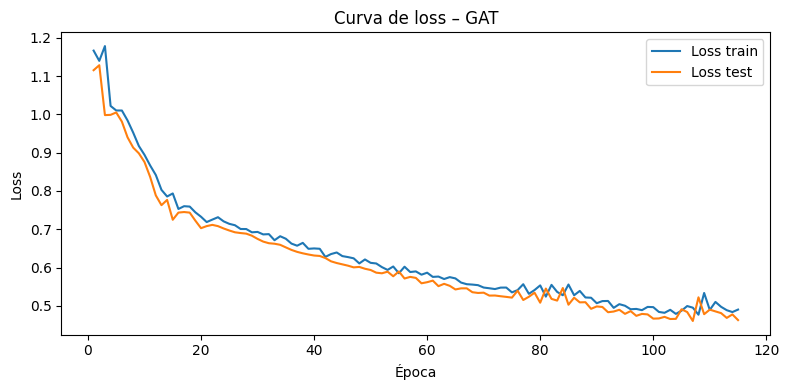

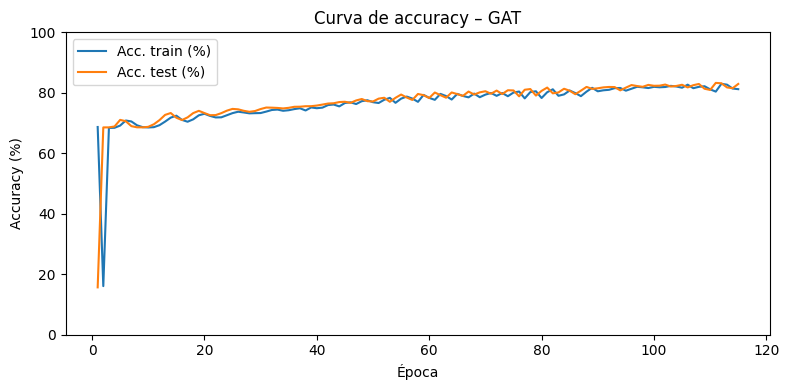

In [ ]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 500
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


# 10 min

Encoder: MLP


=== Training GCN ===
ep01 | loss_tr 1.2497 acc_tr 14.70% | loss_te 0.9963 acc_te 69.23%
ep10 | loss_tr 0.6211 acc_tr 69.49% | loss_te 0.6000 acc_te 69.51%
🛑  Early stop en época 19
Matriz de confusión sin normalizar


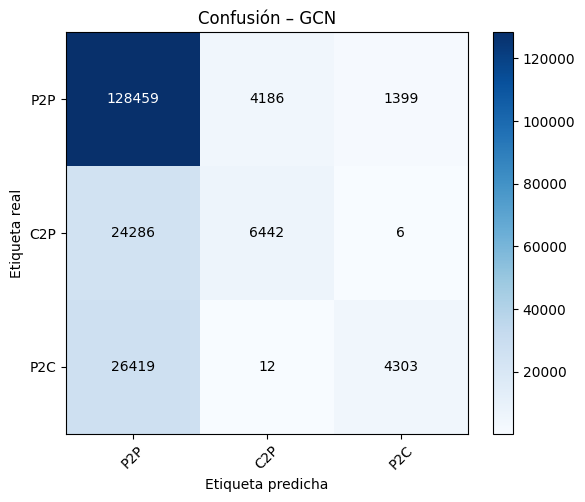

Matriz de confusión normalizada (%)


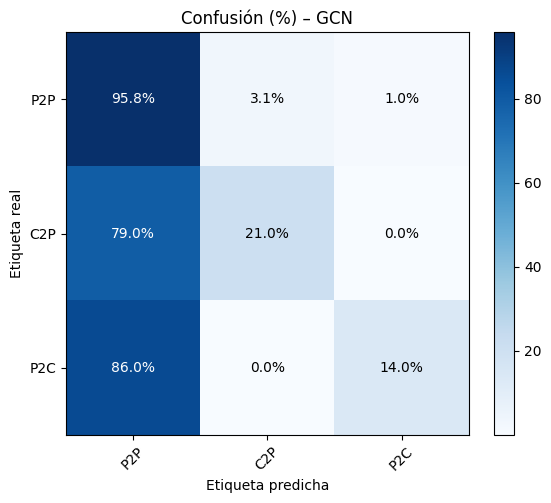

              precision    recall  f1-score   support

           0     0.7170    0.9583    0.8203    134044
           1     0.6055    0.2096    0.3114     30734
           2     0.7539    0.1400    0.2362     30734

    accuracy                         0.7120    195512
   macro avg     0.6921    0.4360    0.4559    195512
weighted avg     0.7053    0.7120    0.6485    195512



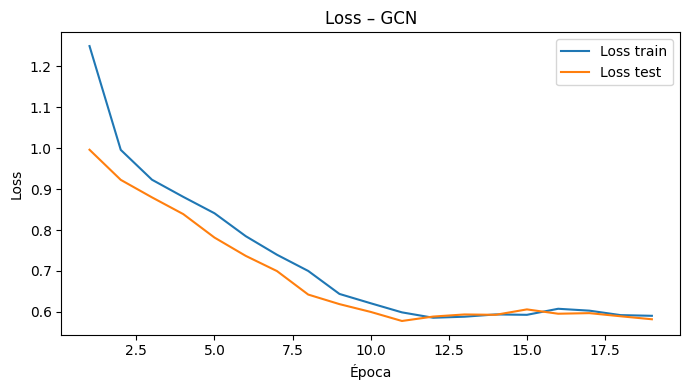

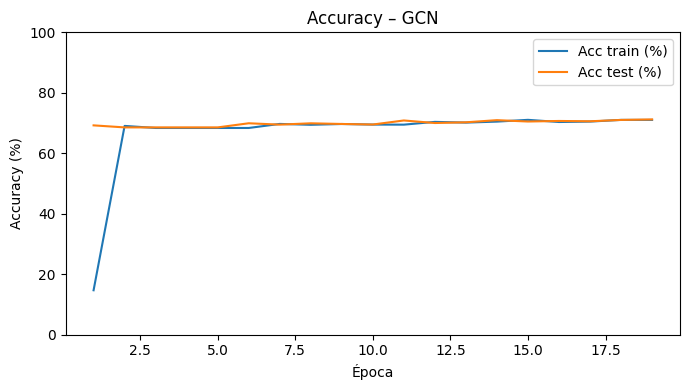


=== Training GraphSAGE ===
ep01 | loss_tr 1.2551 acc_tr 14.17% | loss_te 1.0188 acc_te 65.59%
ep10 | loss_tr 0.8194 acc_tr 68.49% | loss_te 0.7748 acc_te 68.71%
ep20 | loss_tr 0.6707 acc_tr 76.02% | loss_te 0.6454 acc_te 77.61%
ep30 | loss_tr 0.5742 acc_tr 80.48% | loss_te 0.5611 acc_te 81.38%
ep40 | loss_tr 0.5284 acc_tr 81.60% | loss_te 0.5122 acc_te 82.28%
ep50 | loss_tr 0.4936 acc_tr 82.48% | loss_te 0.4898 acc_te 82.53%
ep60 | loss_tr 0.4975 acc_tr 82.40% | loss_te 0.5009 acc_te 82.06%
ep70 | loss_tr 0.4556 acc_tr 84.67% | loss_te 0.4437 acc_te 84.78%
ep80 | loss_tr 0.4343 acc_tr 85.61% | loss_te 0.4206 acc_te 86.16%
ep90 | loss_tr 0.4155 acc_tr 86.46% | loss_te 0.3977 acc_te 86.82%
ep100 | loss_tr 0.3942 acc_tr 87.35% | loss_te 0.3801 acc_te 87.81%
ep110 | loss_tr 0.3787 acc_tr 87.39% | loss_te 0.3628 acc_te 88.02%
ep120 | loss_tr 0.3566 acc_tr 88.29% | loss_te 0.3473 acc_te 88.58%
ep130 | loss_tr 0.3538 acc_tr 88.24% | loss_te 0.3349 acc_te 88.99%
ep140 | loss_tr 0.3628 acc_tr 

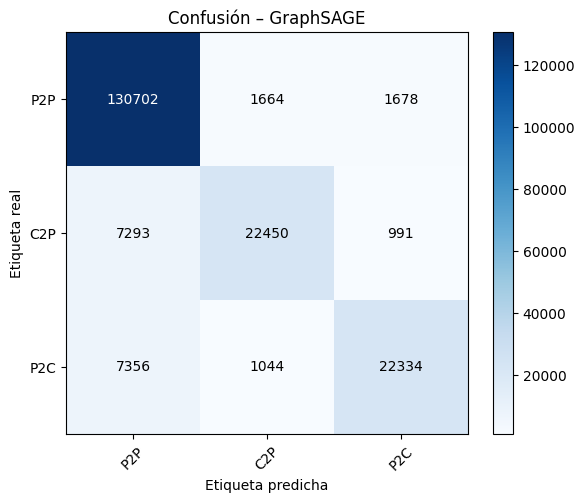

Matriz de confusión normalizada (%)


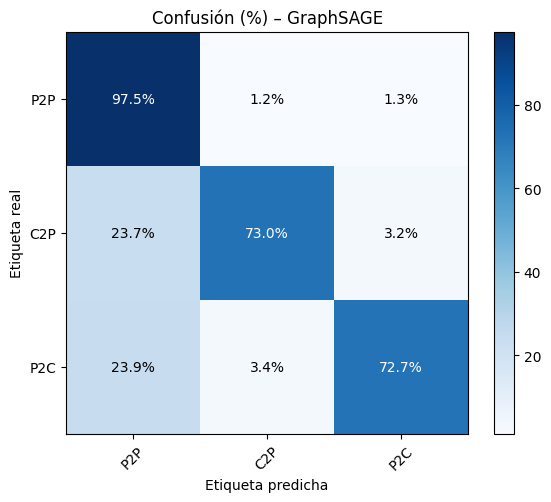

              precision    recall  f1-score   support

           0     0.8992    0.9751    0.9356    134044
           1     0.8924    0.7305    0.8033     30734
           2     0.8933    0.7267    0.8014     30734

    accuracy                         0.8976    195512
   macro avg     0.8949    0.8107    0.8468    195512
weighted avg     0.8972    0.8976    0.8937    195512



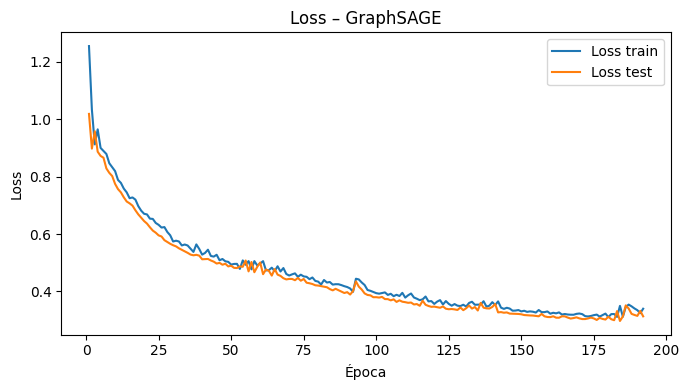

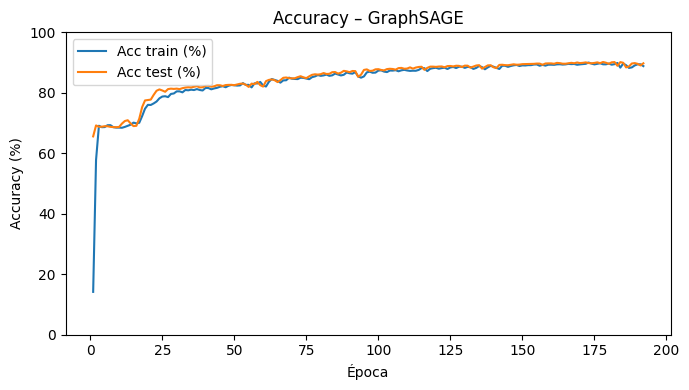


=== Training GAT ===
ep01 | loss_tr 1.0725 acc_tr 19.78% | loss_te 0.8675 acc_te 68.60%
ep10 | loss_tr 0.8109 acc_tr 68.45% | loss_te 0.8185 acc_te 68.57%
🛑  Early stop en época 17
Matriz de confusión sin normalizar


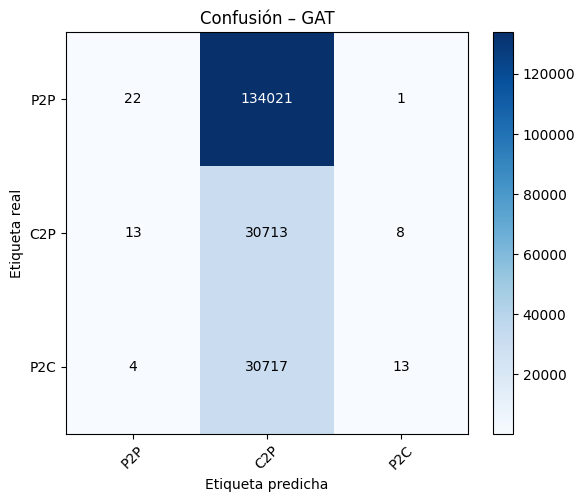

Matriz de confusión normalizada (%)


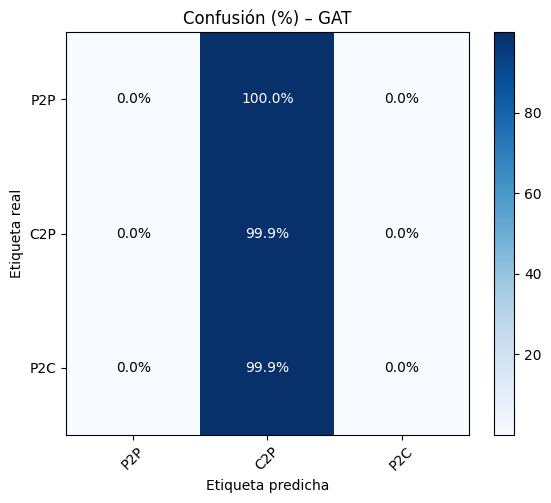

              precision    recall  f1-score   support

           0     0.5641    0.0002    0.0003    134044
           1     0.1571    0.9993    0.2716     30734
           2     0.5909    0.0004    0.0008     30734

    accuracy                         0.1573    195512
   macro avg     0.4374    0.3333    0.0909    195512
weighted avg     0.5043    0.1573    0.0430    195512



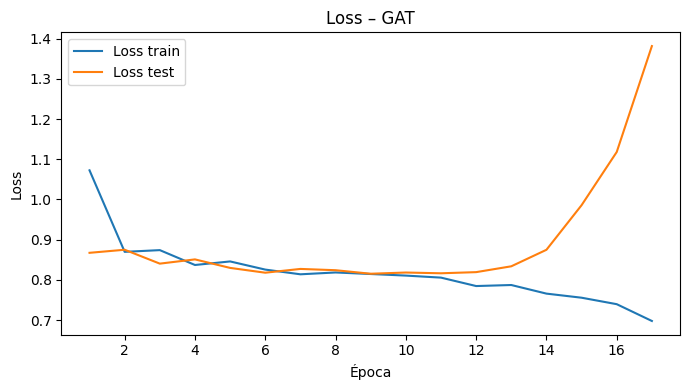

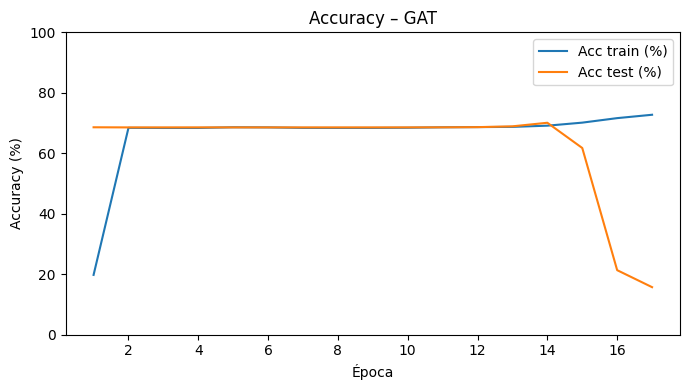

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1.- Parámetros globales
# --------------------------
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 500
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# 2.- Datos y máscaras
# --------------------------
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # 3.- Train
        # --------------------------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # 4.- Test
        # --------------------------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # 5.- Guarda histórico
        # --------------------------
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # 6.- Early stopping
        # --------------------------
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"Ep {ep:3d} | "
                  f"loss_tr={loss.item():.4f}  acc_tr={acc_tr*100:.2f}% | "
                  f"loss_te={loss_te:.4f}  acc_te={acc_t*100:.2f}%")

    # 7.- Evaluación final
    # --------------------------
    model.load_state_dict(best_w)
    with torch.no_grad():
        h_fin   = model.encode(g, feat)
        logits  = model.decodeMLP(g, h_fin)
        preds_f = logits[test_m].argmax(1).cpu()
        truth_f = labels[test_m].cpu()

    cm = confusion_matrix(truth_f, preds_f)
    print(classification_report(truth_f, preds_f, target_names=["P2P", "C2P", "P2C"], digits=4))

    plot_confusion_matrix_2(
        cm, classes=["P2P", "C2P", "P2C"], normalize=True,
        title=f"Confusión (%) – {name}", save=False
    )

    # 8.- Curvas de entrenamiento
    # --------------------------
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")

# 4 min

### Caso 1: Se utiliza grafo con atributos de grado de entrada y salida

In [43]:
# CASO 1: Grafo con atributos de grado de entrada y salida:
# ---------------------------------------
INTERNETGRAPH_FILE = DATA_PATH + '/dgl_graph/2024/degree'

In [44]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [45]:

index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path= INTERNETGRAPH_FILE,
    index_graph=index_graph,            # grafo de febrero
    caida_path=RELATIONSHIPS_FILE,
    simplify=True, 
)
gnn.split_edges_classification(train_size=0.8, seed=42)



[LOAD DATASET] Leyendo CSV …
Done saving data into cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] Simplificando  …
[LOAD DATASET] Etiquetando CAIDA → /media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:00, 529017.85it/s]


[CAIDA] Añadidas 977494 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[split] train=782042  test=195512
  clases train: {1: 123677, 0: 534688, 2: 123677}


Encode : Bilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1108 acc_tr 15.71% | loss_te 1.0704 acc_te 68.56%
ep10  loss_tr 0.8014 acc_tr 68.32% | loss_te 0.7963 acc_te 67.67%
ep20  loss_tr 0.6622 acc_tr 69.12% | loss_te 0.6554 acc_te 68.87%
ep30  loss_tr 0.6313 acc_tr 70.99% | loss_te 0.6272 acc_te 71.31%
ep40  loss_tr 0.6030 acc_tr 71.18% | loss_te 0.5976 acc_te 72.16%
ep50  loss_tr 0.5725 acc_tr 72.83% | loss_te 0.5648 acc_te 72.88%
ep60  loss_tr 0.5303 acc_tr 73.67% | loss_te 0.5221 acc_te 74.46%
ep70  loss_tr 0.4851 acc_tr 80.20% | loss_te 0.4742 acc_te 78.86%
ep80  loss_tr 0.4475 acc_tr 83.34% | loss_te 0.4356 acc_te 84.08%
ep90  loss_tr 0.4224 acc_tr 85.33% | loss_te 0.4092 acc_te 87.49%
ep100  loss_tr 0.4082 acc_tr 86.01% | loss_te 0.3883 acc_te 87.79%
ep110  loss_tr 0.3856 acc_tr 87.89% | loss_te 0.3770 acc_te 88.06%
ep120  loss_tr 0.3772 acc_tr 88.75% | loss_te 0.3676 acc_te 88.44%
ep130  loss_tr 0.3759 acc_tr 88.76% | loss_te 0.3643 acc_te 88.30%
🛑  Early stop en epoch 136
Matriz de co

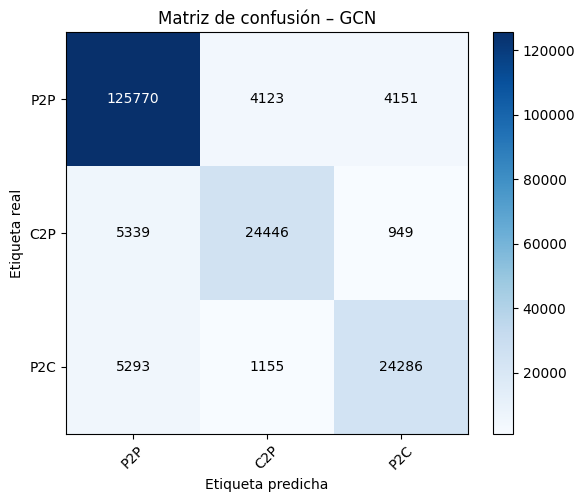

Matriz de confusión normalizada (%)


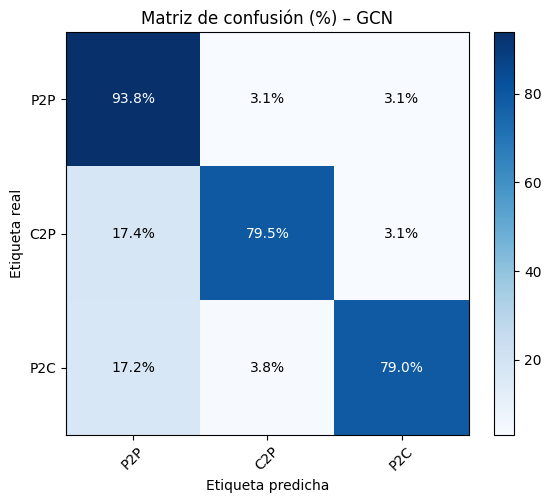

              precision    recall  f1-score   support

           0     0.9221    0.9383    0.9301    134044
           1     0.8224    0.7954    0.8087     30734
           2     0.8264    0.7902    0.8079     30734

    accuracy                         0.8925    195512
   macro avg     0.8570    0.8413    0.8489    195512
weighted avg     0.8914    0.8925    0.8918    195512



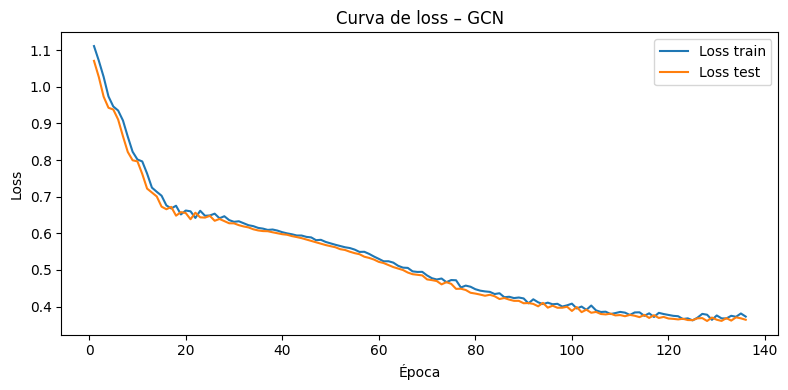

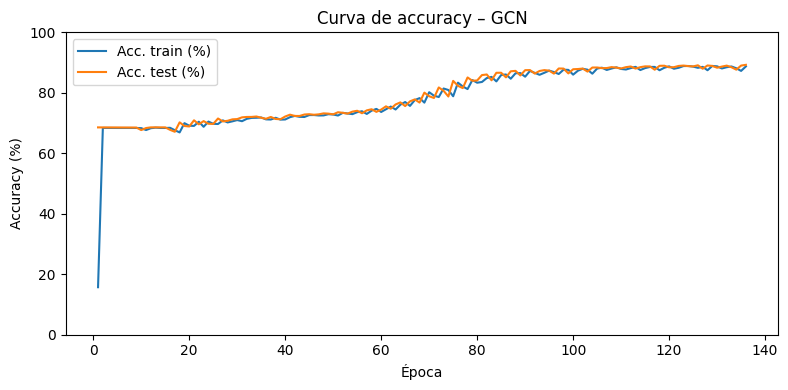


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 1.5009 acc_tr 55.36% | loss_te 0.9895 acc_te 68.75%
ep10  loss_tr 0.8242 acc_tr 69.87% | loss_te 0.7127 acc_te 73.92%
ep20  loss_tr 0.6765 acc_tr 76.12% | loss_te 0.6578 acc_te 76.09%
ep30  loss_tr 0.6177 acc_tr 78.22% | loss_te 0.6181 acc_te 77.81%
ep40  loss_tr 0.5904 acc_tr 78.76% | loss_te 0.5816 acc_te 78.47%
ep50  loss_tr 0.5567 acc_tr 80.13% | loss_te 0.5495 acc_te 79.35%
ep60  loss_tr 0.5158 acc_tr 81.33% | loss_te 0.5211 acc_te 80.02%
ep70  loss_tr 0.4974 acc_tr 81.83% | loss_te 0.5041 acc_te 80.20%
ep80  loss_tr 0.4809 acc_tr 82.36% | loss_te 0.4907 acc_te 80.81%
ep90  loss_tr 0.4615 acc_tr 83.34% | loss_te 0.4759 acc_te 81.08%
ep100  loss_tr 0.4524 acc_tr 83.36% | loss_te 0.4671 acc_te 81.34%
ep110  loss_tr 0.4473 acc_tr 84.47% | loss_te 0.4656 acc_te 81.07%
ep120  loss_tr 0.4320 acc_tr 84.46% | loss_te 0.4522 acc_te 81.75%
ep130  loss_tr 0.4245 acc_tr 85.07% | loss_te 0.4411 acc_te 82.24%
ep140  loss_tr 0.4203 acc_tr 84.8

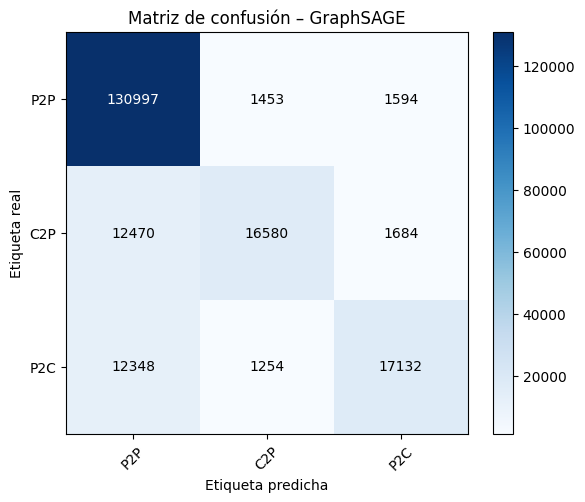

Matriz de confusión normalizada (%)


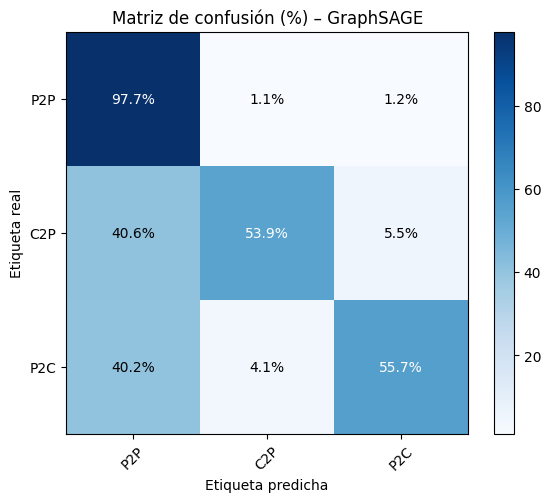

              precision    recall  f1-score   support

           0     0.8407    0.9773    0.9039    134044
           1     0.8596    0.5395    0.6629     30734
           2     0.8394    0.5574    0.6700     30734

    accuracy                         0.8424    195512
   macro avg     0.8466    0.6914    0.7456    195512
weighted avg     0.8435    0.8424    0.8292    195512



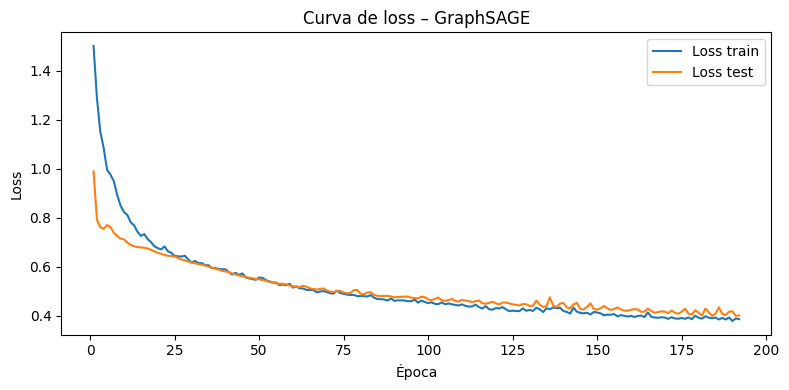

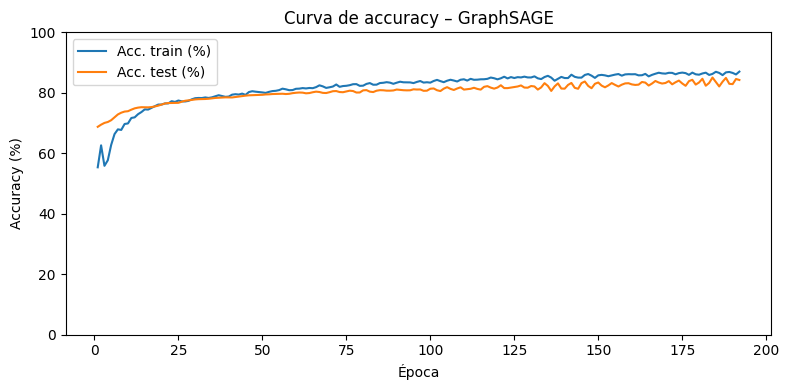


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1057 acc_tr 15.35% | loss_te 1.0886 acc_te 71.40%
ep10  loss_tr 0.7967 acc_tr 70.37% | loss_te 0.7626 acc_te 71.56%
ep20  loss_tr 0.7281 acc_tr 73.35% | loss_te 0.7239 acc_te 73.39%
ep30  loss_tr 0.7125 acc_tr 72.26% | loss_te 0.7062 acc_te 72.33%
ep40  loss_tr 0.6757 acc_tr 73.79% | loss_te 0.6702 acc_te 74.82%
ep50  loss_tr 0.6191 acc_tr 75.38% | loss_te 0.6061 acc_te 75.69%
ep60  loss_tr 0.5832 acc_tr 77.54% | loss_te 0.5584 acc_te 77.36%
ep70  loss_tr 0.5486 acc_tr 78.50% | loss_te 0.5328 acc_te 78.61%
ep80  loss_tr 0.5344 acc_tr 79.69% | loss_te 0.5116 acc_te 79.81%
ep90  loss_tr 0.5157 acc_tr 80.71% | loss_te 0.4969 acc_te 80.77%
ep100  loss_tr 0.5029 acc_tr 81.07% | loss_te 0.4851 acc_te 81.40%
ep110  loss_tr 0.4917 acc_tr 81.51% | loss_te 0.4797 acc_te 81.69%
ep120  loss_tr 0.4684 acc_tr 82.72% | loss_te 0.4728 acc_te 81.96%
ep130  loss_tr 0.4664 acc_tr 82.87% | loss_te 0.4653 acc_te 82.27%
🛑  Early stop en epoch 135
Matriz de co

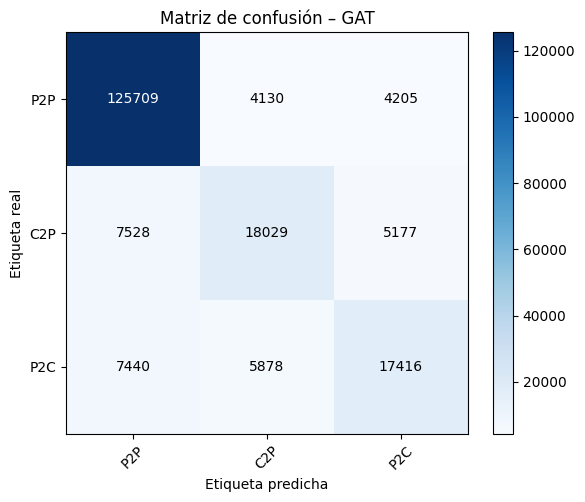

Matriz de confusión normalizada (%)


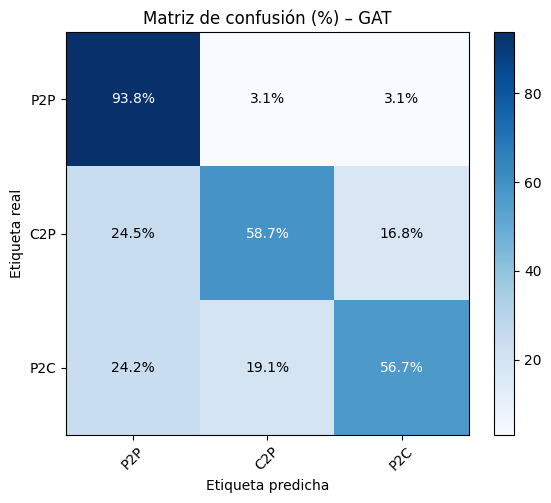

              precision    recall  f1-score   support

           0     0.8936    0.9378    0.9152    134044
           1     0.6430    0.5866    0.6135     30734
           2     0.6499    0.5667    0.6054     30734

    accuracy                         0.8243    195512
   macro avg     0.7288    0.6970    0.7114    195512
weighted avg     0.8159    0.8243    0.8191    195512



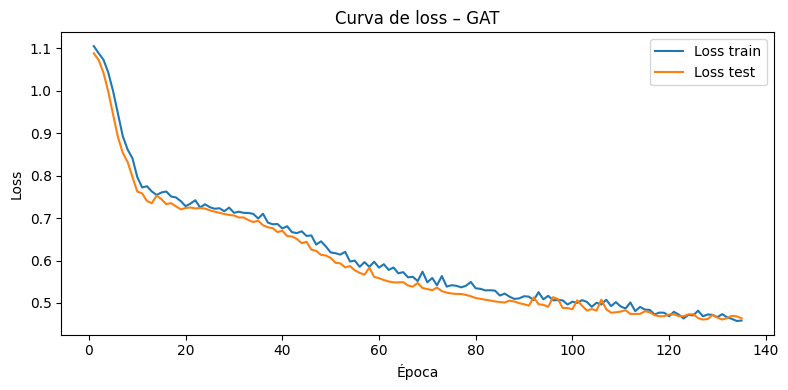

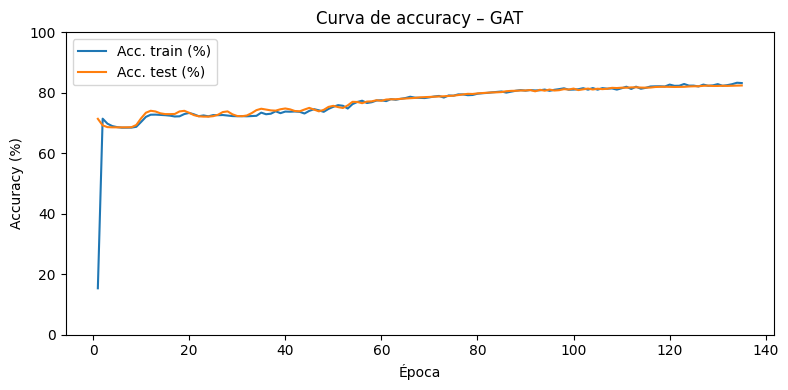

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1.- Parámetros globales
# --------------------------
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 500
lr        = 1e-2
patience  = 15
n_classes = 3

# 2.- Datos y máscaras
# --------------------------
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, n_classes=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    # histórico
    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for epoch in range(1, epochs + 1):
        # 3.- Train
        # --------------------------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # 4.- Test
        # --------------------------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # 5.- Guarda históricos
        # --------------------------
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # 6.- Early stopping
        # --------------------------
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # 7.- Evaluación final
    # --------------------------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_fin = model.decodeBilinear(g, model.encode(g, feat))
        preds_best = logits_fin[test_m].argmax(1).cpu()
        truth      = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    print(classification_report(truth, preds_best, target_names=["P2P","C2P","P2C"], digits=4))

    plot_confusion_matrix_2(
        cm, classes=["P2P","C2P","P2C"], normalize=True,
        title=f"Confusión (%) – {name}", save=False
    )

    # 8.- Curvas de entrenamiento
    # --------------------------
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")

# 7 min

Encoder : MLP


=== Training GCN ===
ep01 | loss_tr 0.9765 acc_tr 68.37% | loss_te 0.9422 acc_te 68.56%
ep10 | loss_tr 0.7109 acc_tr 68.37% | loss_te 0.7024 acc_te 68.13%
ep20 | loss_tr 0.6720 acc_tr 68.47% | loss_te 0.6629 acc_te 69.30%
ep30 | loss_tr 0.6482 acc_tr 70.68% | loss_te 0.6446 acc_te 70.86%
ep40 | loss_tr 0.6354 acc_tr 70.70% | loss_te 0.6323 acc_te 70.61%
ep50 | loss_tr 0.6189 acc_tr 70.94% | loss_te 0.6136 acc_te 71.15%
ep60 | loss_tr 0.5839 acc_tr 71.91% | loss_te 0.5750 acc_te 72.44%
ep70 | loss_tr 0.5066 acc_tr 76.21% | loss_te 0.5008 acc_te 76.75%
ep80 | loss_tr 0.4656 acc_tr 81.69% | loss_te 0.4633 acc_te 81.68%
ep90 | loss_tr 0.4568 acc_tr 83.13% | loss_te 0.4399 acc_te 84.19%
ep100 | loss_tr 0.4366 acc_tr 84.44% | loss_te 0.4276 acc_te 84.91%
ep110 | loss_tr 0.4122 acc_tr 85.45% | loss_te 0.4075 acc_te 85.53%
ep120 | loss_tr 0.3958 acc_tr 85.86% | loss_te 0.3878 acc_te 86.18%
ep130 | loss_tr 0.3728 acc_tr 86.66% | loss_te 0.3696 acc_te 86.67%
ep140 | loss_tr 0.3582 acc_tr 87.22%

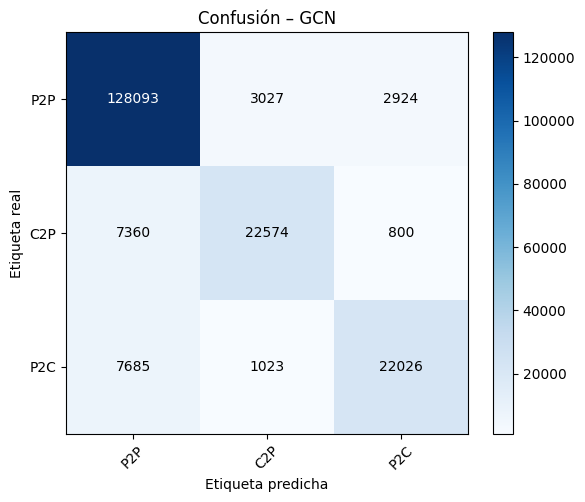

Matriz de confusión normalizada (%)


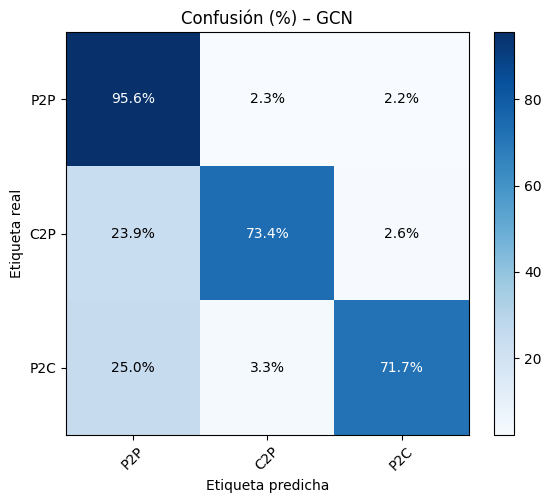

              precision    recall  f1-score   support

           0     0.8949    0.9556    0.9243    134044
           1     0.8479    0.7345    0.7871     30734
           2     0.8554    0.7167    0.7799     30734

    accuracy                         0.8833    195512
   macro avg     0.8661    0.8023    0.8304    195512
weighted avg     0.8813    0.8833    0.8800    195512



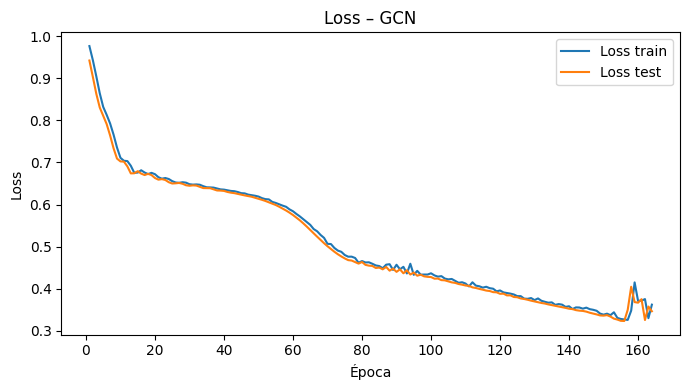

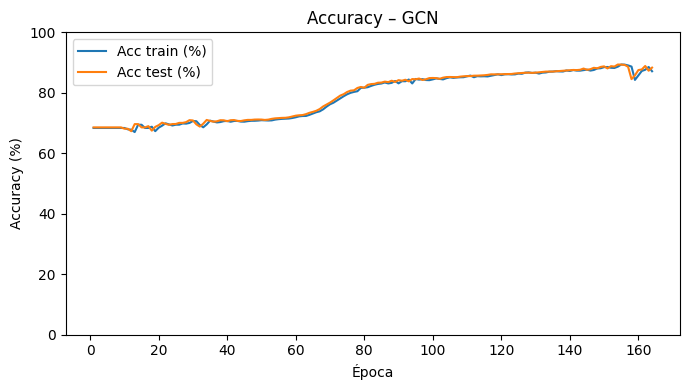


=== Training GraphSAGE ===
ep01 | loss_tr 1.1702 acc_tr 15.87% | loss_te 0.9627 acc_te 68.56%
ep10 | loss_tr 0.8545 acc_tr 68.37% | loss_te 0.8479 acc_te 68.56%
ep20 | loss_tr 0.8077 acc_tr 68.42% | loss_te 0.7901 acc_te 68.80%
ep30 | loss_tr 0.7492 acc_tr 72.79% | loss_te 0.7271 acc_te 74.28%
ep40 | loss_tr 0.7055 acc_tr 75.26% | loss_te 0.6740 acc_te 76.18%
ep50 | loss_tr 0.6443 acc_tr 76.72% | loss_te 0.6168 acc_te 77.26%
ep60 | loss_tr 0.6044 acc_tr 77.99% | loss_te 0.5725 acc_te 78.96%
ep70 | loss_tr 0.5677 acc_tr 79.46% | loss_te 0.5448 acc_te 80.27%
ep80 | loss_tr 0.5463 acc_tr 79.72% | loss_te 0.5251 acc_te 80.64%
ep90 | loss_tr 0.5316 acc_tr 80.65% | loss_te 0.5098 acc_te 80.98%
ep100 | loss_tr 0.5142 acc_tr 80.65% | loss_te 0.4953 acc_te 81.20%
ep110 | loss_tr 0.4999 acc_tr 81.48% | loss_te 0.4807 acc_te 82.06%
ep120 | loss_tr 0.4815 acc_tr 82.40% | loss_te 0.4626 acc_te 82.44%
ep130 | loss_tr 0.4614 acc_tr 83.39% | loss_te 0.4457 acc_te 83.28%
ep140 | loss_tr 0.4421 acc_tr 

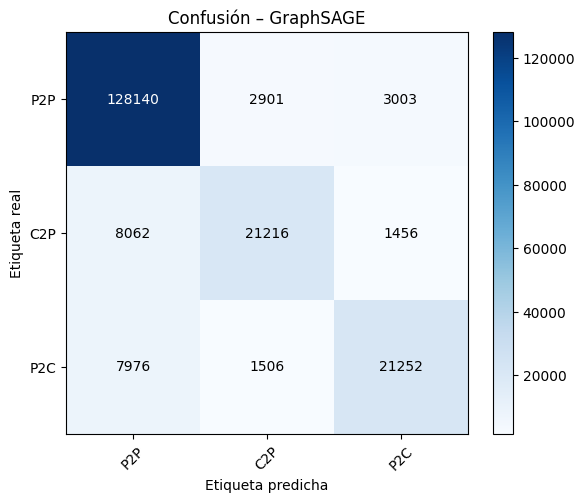

Matriz de confusión normalizada (%)


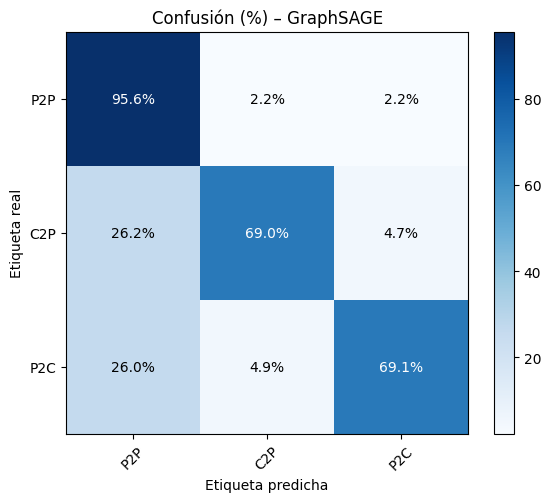

              precision    recall  f1-score   support

           0     0.8888    0.9560    0.9211    134044
           1     0.8280    0.6903    0.7529     30734
           2     0.8266    0.6915    0.7530     30734

    accuracy                         0.8726    195512
   macro avg     0.8478    0.7792    0.8090    195512
weighted avg     0.8694    0.8726    0.8683    195512



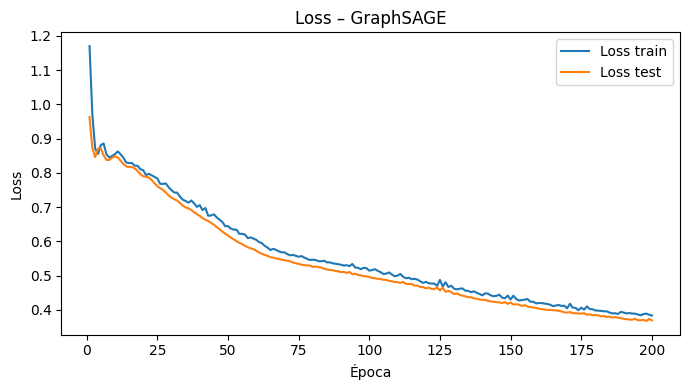

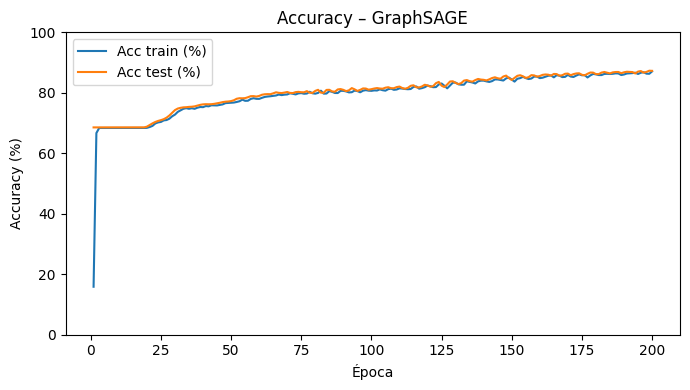


=== Training GAT ===
ep01 | loss_tr 1.1572 acc_tr 15.81% | loss_te 1.1146 acc_te 15.72%
ep10 | loss_tr 0.8973 acc_tr 68.37% | loss_te 0.9039 acc_te 68.56%
ep20 | loss_tr 0.8481 acc_tr 68.37% | loss_te 0.8380 acc_te 68.56%
ep30 | loss_tr 0.7730 acc_tr 70.95% | loss_te 0.7561 acc_te 71.77%
ep40 | loss_tr 0.7360 acc_tr 70.63% | loss_te 0.7236 acc_te 71.85%
ep50 | loss_tr 0.7108 acc_tr 73.05% | loss_te 0.7032 acc_te 73.71%
ep60 | loss_tr 0.6914 acc_tr 74.20% | loss_te 0.6829 acc_te 74.76%
ep70 | loss_tr 0.6699 acc_tr 74.39% | loss_te 0.6616 acc_te 74.90%
ep80 | loss_tr 0.6448 acc_tr 74.54% | loss_te 0.6332 acc_te 74.92%
ep90 | loss_tr 0.6022 acc_tr 75.56% | loss_te 0.5978 acc_te 76.06%
ep100 | loss_tr 0.5654 acc_tr 78.31% | loss_te 0.5630 acc_te 78.43%
ep110 | loss_tr 0.5350 acc_tr 80.34% | loss_te 0.5419 acc_te 79.76%
ep120 | loss_tr 0.4985 acc_tr 81.82% | loss_te 0.4850 acc_te 81.74%
ep130 | loss_tr 0.4757 acc_tr 83.27% | loss_te 0.4652 acc_te 82.76%
ep140 | loss_tr 0.4478 acc_tr 84.08%

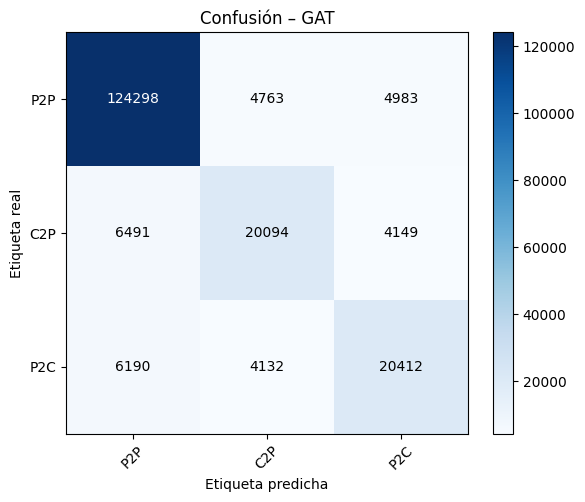

Matriz de confusión normalizada (%)


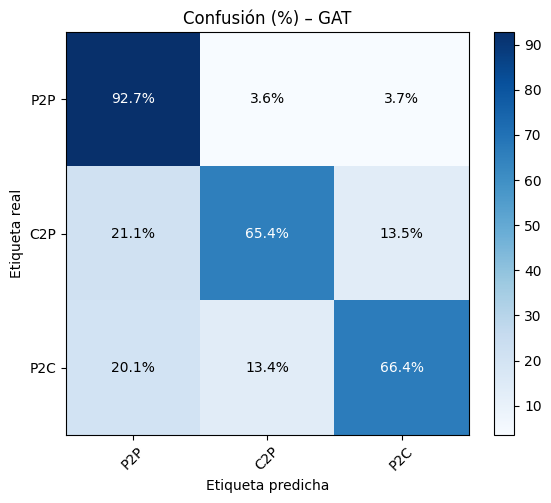

              precision    recall  f1-score   support

           0     0.9074    0.9273    0.9173    134044
           1     0.6932    0.6538    0.6729     30734
           2     0.6909    0.6642    0.6773     30734

    accuracy                         0.8429    195512
   macro avg     0.7638    0.7484    0.7558    195512
weighted avg     0.8397    0.8429    0.8411    195512



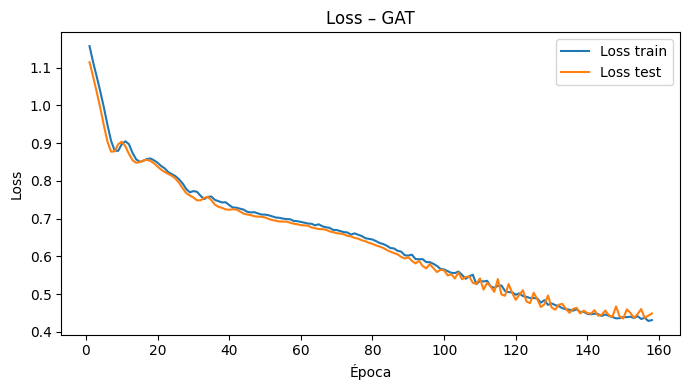

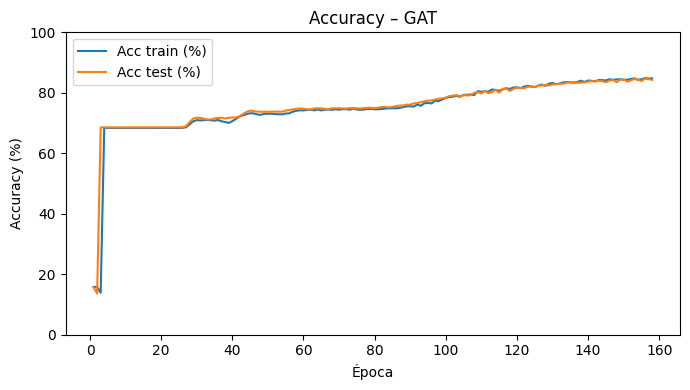

In [47]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
lr        = 0.01
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, NUM_EPOCHS + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


### Caso 2: Utilizando grafo con atributos de PeeringDB y muestreo aleatorio de vecinos (Random Neighbour Sampling)

In [6]:
# CASO 0,2,3: Grafo con atributos de nodos extraídos de PeeringDB
# ---------------------------------------
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'

# Numero de vecinos
# -----------------------
N_NEIGHBORS = 15

In [7]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}

In [8]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path= INTERNETGRAPH_FILE,
    index_graph=index_graph,            # grafo de febrero
    caida_path=RELATIONSHIPS_FILE,
    simplify=True, 
)

gnn.split_edges_classification(train_size=0.8, seed=42)
# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)

# 9 seg


[LOAD DATASET] Leyendo CSV …
Done loading data from cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] Simplificando  …
[LOAD DATASET] Etiquetando CAIDA → /media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 466182.09it/s]


[CAIDA] Añadidas 977494 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[split] train=782042  test=195512
  clases train: {1: 123677, 0: 534688, 2: 123677}
[split] train=782042  test=195512
  clases train: {1: 123677, 0: 534688, 2: 123677}


In [51]:
from collections import Counter
cnt = Counter(gnn.dgl_graph.edata['Relationship'][train_eids].tolist())
print(cnt)   # → algo como {0: 5 × 10⁶, 1: 8 × 10⁵, 2: 8 × 10⁵}

Counter({0: 534688, 2: 123677, 1: 123677})


In [9]:
train_mask = gnn.dgl_graph.edata['train_mask']
test_mask = gnn.dgl_graph.edata['test_mask']

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")


TRAIN IDX: tensor([False, False, False,  ...,  True,  True,  True])
TEST IDX: tensor([False, False, False,  ..., False, False, False])
TRAIN NIDS: tensor([    654,    8332,    8574,  ..., 1126928, 1126929, 1126930])
TEST NIDS: tensor([  35152,   61123,   62116,  ..., 1126910, 1126917, 1126918])


In [10]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([N_NEIGHBORS, N_NEIGHBORS])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([N_NEIGHBORS,N_NEIGHBORS])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)


In [11]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample
import tqdm

models = {
    "GCN-Sampler": GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler": GATSample
}


===== Entrenando GCN-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:15<00:00, 50.68it/s]


ep001 | loss_tr 0.3152 acc_tr 88.73% | loss_te 0.2646 acc_te 90.85%


100%|██████████| 783/783 [00:14<00:00, 52.93it/s]


ep005 | loss_tr 0.2356 acc_tr 92.03% | loss_te 0.2457 acc_te 91.59%


100%|██████████| 783/783 [00:14<00:00, 52.39it/s]


ep010 | loss_tr 0.2278 acc_tr 92.26% | loss_te 0.2315 acc_te 92.09%


100%|██████████| 783/783 [00:15<00:00, 51.88it/s]


ep015 | loss_tr 0.2216 acc_tr 92.46% | loss_te 0.2334 acc_te 92.17%


100%|██████████| 783/783 [00:12<00:00, 64.31it/s]


ep020 | loss_tr 0.2175 acc_tr 92.61% | loss_te 0.2234 acc_te 92.43%


100%|██████████| 783/783 [00:15<00:00, 50.94it/s]


ep025 | loss_tr 0.2168 acc_tr 92.68% | loss_te 0.2228 acc_te 92.50%


100%|██████████| 783/783 [00:16<00:00, 48.77it/s]


🛑  Early-stop en época 30
              precision    recall  f1-score   support

           0     0.9165    0.9840    0.9490    134044
           1     0.9080    0.7841    0.8415     30734
           2     0.9299    0.7580    0.8352     30734

    accuracy                         0.9170    195512
   macro avg     0.9181    0.8420    0.8752    195512
weighted avg     0.9172    0.9170    0.9142    195512

Matriz de confusión normalizada (%)


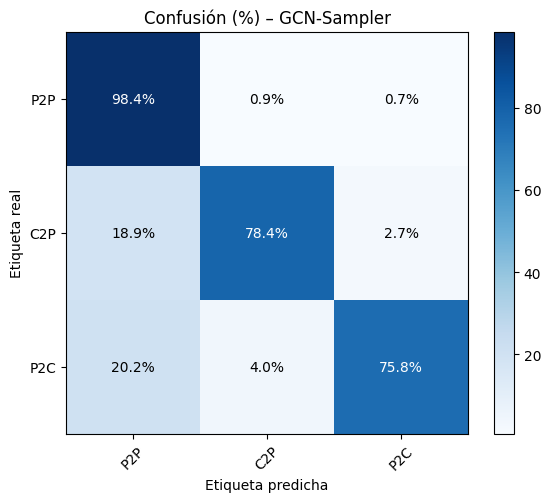

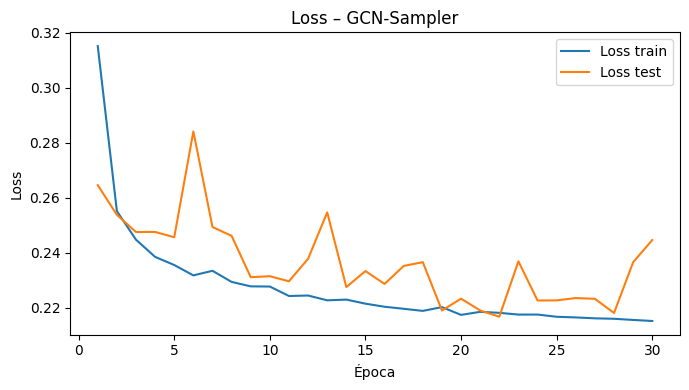

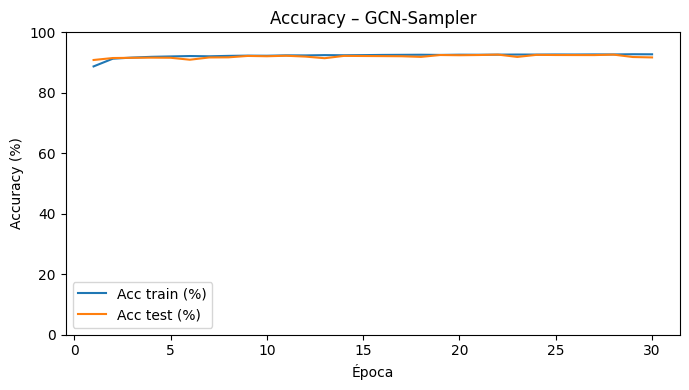

MAE = 0.1195 | R² = 0.6583

===== Entrenando SAGE-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:14<00:00, 53.24it/s]


ep001 | loss_tr 0.3122 acc_tr 89.01% | loss_te 0.2618 acc_te 91.00%


100%|██████████| 783/783 [00:15<00:00, 50.39it/s]


ep005 | loss_tr 0.2372 acc_tr 91.96% | loss_te 0.2392 acc_te 91.72%


100%|██████████| 783/783 [00:14<00:00, 52.25it/s]


ep010 | loss_tr 0.2272 acc_tr 92.28% | loss_te 0.2306 acc_te 92.18%


100%|██████████| 783/783 [00:14<00:00, 52.62it/s]


ep015 | loss_tr 0.2215 acc_tr 92.51% | loss_te 0.2288 acc_te 92.23%


100%|██████████| 783/783 [00:17<00:00, 45.72it/s]


ep020 | loss_tr 0.2182 acc_tr 92.63% | loss_te 0.2395 acc_te 91.89%


100%|██████████| 783/783 [00:15<00:00, 49.24it/s]


ep025 | loss_tr 0.2153 acc_tr 92.74% | loss_te 0.2187 acc_te 92.65%


100%|██████████| 783/783 [00:16<00:00, 47.37it/s]


ep030 | loss_tr 0.2140 acc_tr 92.81% | loss_te 0.2271 acc_te 92.19%


100%|██████████| 783/783 [00:18<00:00, 43.28it/s]


ep035 | loss_tr 0.2125 acc_tr 92.84% | loss_te 0.2383 acc_te 92.28%


100%|██████████| 783/783 [00:13<00:00, 59.12it/s]


🛑  Early-stop en época 36
              precision    recall  f1-score   support

           0     0.9264    0.9796    0.9522    134044
           1     0.9087    0.7985    0.8500     30734
           2     0.9137    0.7956    0.8506     30734

    accuracy                         0.9222    195512
   macro avg     0.9162    0.8579    0.8843    195512
weighted avg     0.9216    0.9222    0.9202    195512

Matriz de confusión normalizada (%)


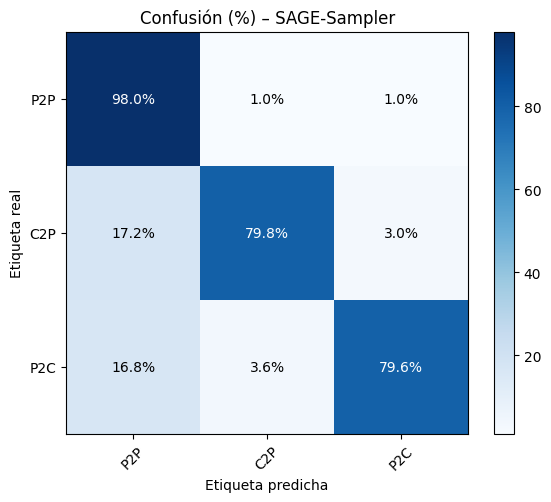

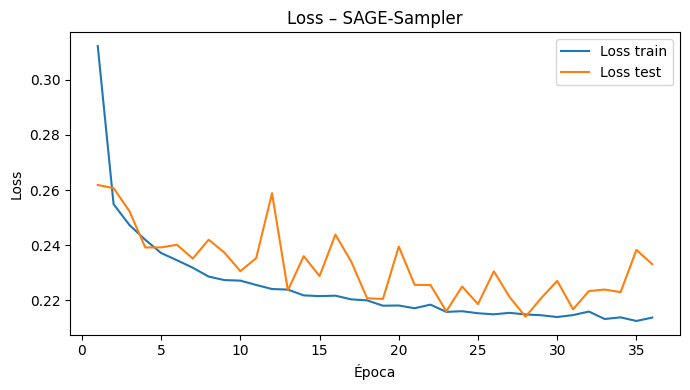

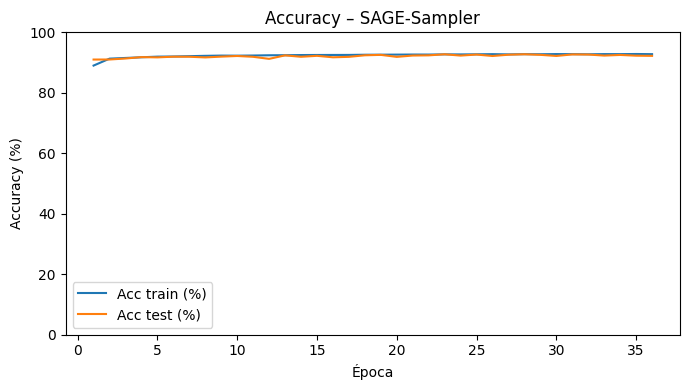

MAE = 0.1114 | R² = 0.6834

===== Entrenando GAT-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:26<00:00, 29.61it/s]


ep001 | loss_tr 0.3865 acc_tr 86.32% | loss_te 0.3173 acc_te 89.06%


100%|██████████| 783/783 [00:32<00:00, 24.13it/s]


ep005 | loss_tr 0.2595 acc_tr 91.16% | loss_te 0.2596 acc_te 91.05%


100%|██████████| 783/783 [00:31<00:00, 25.23it/s]


ep010 | loss_tr 0.2433 acc_tr 91.73% | loss_te 0.2367 acc_te 91.89%


100%|██████████| 783/783 [00:36<00:00, 21.74it/s]


ep015 | loss_tr 0.2401 acc_tr 91.87% | loss_te 0.2363 acc_te 91.93%


100%|██████████| 783/783 [00:30<00:00, 25.96it/s]


ep020 | loss_tr 0.2385 acc_tr 91.93% | loss_te 0.2458 acc_te 91.84%


100%|██████████| 783/783 [00:30<00:00, 25.34it/s]


🛑  Early-stop en época 23
              precision    recall  f1-score   support

           0     0.9382    0.9652    0.9515    134044
           1     0.8725    0.8113    0.8407     30734
           2     0.8688    0.8206    0.8440     30734

    accuracy                         0.9183    195512
   macro avg     0.8932    0.8657    0.8788    195512
weighted avg     0.9170    0.9183    0.9172    195512

Matriz de confusión normalizada (%)


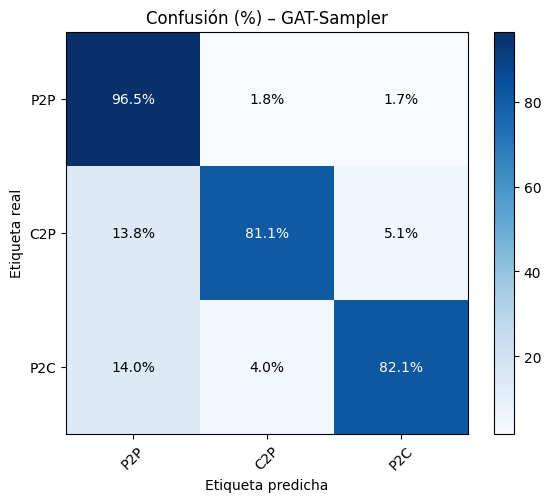

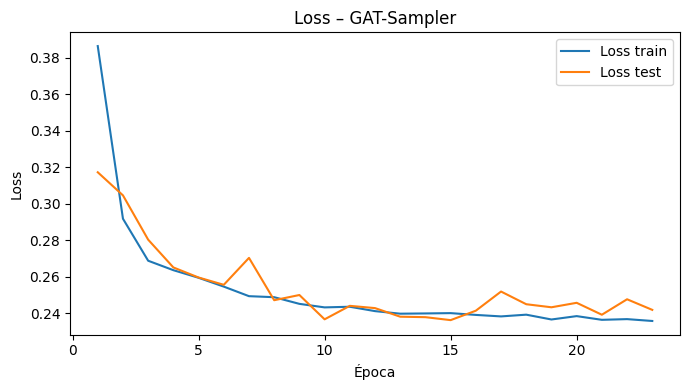

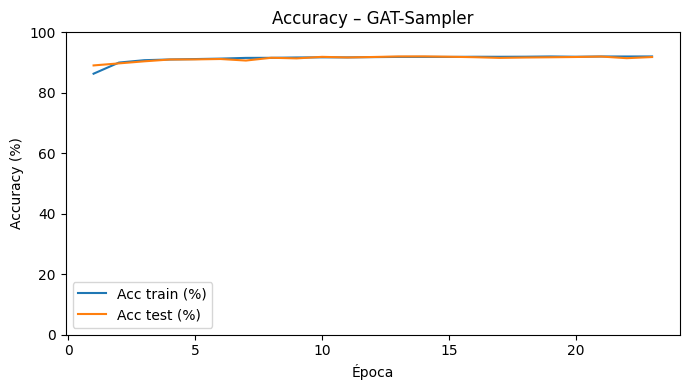

MAE = 0.1151 | R² = 0.6773


In [ ]:
import tqdm, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    mean_absolute_error, r2_score
)

# 1.- Hiperparámetros
# --------------------------
in_feats   = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_dim = 64
emb_dim    = 32
n_classes  = 3
lr         = 0.01
patience   = 8
device     = "cuda" if torch.cuda.is_available() else "cpu"

# 2.- Bucle sobre modelos
# --------------------------
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, hidden_dim, emb_dim,
                  out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # almacenamos historial por época
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0         # early-stopping

    # 3.- Entrenamiento por época
    # --------------------------
    for ep in range(1, NUM_EPOCHS + 1):
        # 4.- Entrenamiento
        # --------------------------
        model.train()
        loss_sum = corr = total = 0

        for input_nodes, output_graph, mfgs in tqdm.tqdm(
                train_dataloader):
            mfgs     = list(mfgs)
            edge_ids = output_graph.edata[dgl.EID].to(device)
            inputs        = mfgs[0].srcdata["feat"].to(device)
            y        = gnn.dgl_graph.edata["Relationship"][edge_ids].long().to(device)

            h       = model.encode(mfgs, inputs)               # (N_batch, emb_dim)
            logits  = model.decodeMLP(output_graph, h)    # (E_batch, 3)

            loss = F.cross_entropy(logits, y)
            optim.zero_grad();  loss.backward();  optim.step()

            # métrica de accuracy en batch
            pred = logits.argmax(1)
            corr += (pred == y).sum().item()
            total += len(y)
            loss_sum += loss.item() * len(y)

        loss_tr = loss_sum / total
        acc_tr  = 100 * corr / total

        # 5.- Validación
        # --------------------------
        model.eval()
        loss_sum = corr = total = 0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for input_nodes, output_graph, mfgs in test_dataloader:
                mfgs     = list(mfgs)
                edge_ids = output_graph.edata[dgl.EID].to(device)
                inputs   = mfgs[0].srcdata["feat"].to(device)
                y        = gnn.dgl_graph.edata["Relationship"][edge_ids].long().to(device)

                h_val    = model.encode(mfgs, inputs)
                logits = model.decodeMLP(output_graph, h_val)

                loss_sum += F.cross_entropy(logits, y).item() * len(y)
                pred = logits.argmax(1)

                corr  += (pred == y).sum().item()
                total += len(y)

                preds_all.append(pred.cpu())
                labels_all.append(y.cpu())

        loss_te = loss_sum / total
        acc_te  = 100 * corr / total

        # 6.- Historial + early stopping
        # --------------------------
        hist["loss_tr"].append(loss_tr);  hist["loss_te"].append(loss_te)
        hist["acc_tr"].append(acc_tr);    hist["acc_te"].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 5 == 0 or ep == 1:
            print(f"ep{ep:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # 7.- Evaluación final
    # --------------------------
    model.load_state_dict(best_state)
    preds = torch.cat(preds_all)
    truth = torch.cat(labels_all)

    cm = confusion_matrix(truth, preds)
    print(classification_report(truth, preds, digits=4))

    plot_confusion_matrix_2(
        cm,
        classes=["P2P", "C2P", "P2C"],
        normalize=True,
        title=f"Confusión (%) – {name}",
        fname=f"img/resultados/gnn/end-to-end/{name.lower()}/cm_{name.lower()}",
        save=True  # cambia a False si no quieres guardarla
    )

    # 8.- Gráficos de historial
    # --------------------------
    ep_axis = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["loss_tr"], label="Loss train")
    plt.plot(ep_axis, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["acc_tr"], label="Acc train (%)")
    plt.plot(ep_axis, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    # 9.- Métricas numéricas
    # --------------------------
    mae = mean_absolute_error(truth, preds)
    r2  = r2_score(truth, preds)
    print(f"MAE = {mae:.4f} | R² = {r2:.4f}")

# 32 min

### Caso 3: Se utiliza grafo con atributos de PeeringDB y muestreo basado en comunidades (ClusterGCN) 

parte el grafo en K clusters disjuntos y cada
mini-batch es todo un cluster (no un bloque‐vecinos).

|                              | NeighborSampler (antes)                      | ClusterGCNSampler (ahora)                                                                 |
| ---------------------------- | -------------------------------------------- | ----------------------------------------------------------------------------------------- |
| lo que devuelve `DataLoader` | `(input_nodes, pair_graph, blocks)`          | **un único subgrafo** `subg`                                                              |
| cómo llamo al `encode`       | `model.encode(blocks, x)` (lista de bloques) | `model.encode([subg], x)` **o** `model.encode(subg, x)` si tu `encode` acepta un DGLGraph |

In [12]:
# CASO 0,2,3: Grafo con atributos de nodos extraídos de PeeringDB
# ---------------------------------------
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'

In [13]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}


In [14]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path= INTERNETGRAPH_FILE,
    index_graph=index_graph,            # grafo de febrero
    caida_path=RELATIONSHIPS_FILE,
    simplify=True, 
)

gnn.split_edges_classification(train_size=0.8, seed=42)

[LOAD DATASET] Leyendo CSV …
Done loading data from cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] Simplificando  …
[LOAD DATASET] Etiquetando CAIDA → /media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 479027.46it/s]


[CAIDA] Añadidas 977494 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[split] train=782042  test=195512
  clases train: {1: 123677, 0: 534688, 2: 123677}


In [ ]:
# RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

# gnn = GNN(debug=True)

# # Cargo dataset y etiqueto sgun archivo de relaciones
# gnn.load_dataset(
#     data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
#     force_reload=True,
#     index_graph = 1,  # Indice del grafo a cargar febrero
#     simplify=True,            # ⇐ hazlo sólo una vez
#     caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
# )

# gnn.split_edges_classification(train_size=0.8, seed=42)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:00, 495232.16it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}


In [ ]:

num_parts = 1000                       # ajusta tamaño de cluster
device    = "cuda" if torch.cuda.is_available() else "cpu"

# Creación sampler cluster
# ------------------------------------------
sampler = dgl.dataloading.ClusterGCNSampler(
            gnn.dgl_graph, num_parts,
            prefetch_ndata=['feat'],
            prefetch_edata=['Relationship', 'train_mask', 'test_mask']
            )

# Inndices de clusters = 0 … (num_parts-1)
# ------------------------------------------
cluster_ids = torch.arange(num_parts)

# DataLoader de entrenamiento 
# ------------------------------------------
train_loader = dgl.dataloading.DataLoader(
        gnn.dgl_graph, cluster_ids, sampler,
        batch_size=1, shuffle=True, drop_last=False, device=device)

# DataLoader de test             
# ------------------------------------------
test_loader  = dgl.dataloading.DataLoader(
        gnn.dgl_graph, cluster_ids, sampler,
        batch_size=1, shuffle=False, drop_last=False, device=device)


Convert a graph into a bidirected graph: 0.058 seconds, peak memory: 6.596 GB
Construct multi-constraint weights: 0.001 seconds, peak memory: 6.596 GB
Metis partitioning: 1.182 seconds, peak memory: 6.596 GB


[20:31:21] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 401308 nodes and 1264632 edges into 1000 parts and get 492005 edge cuts


Cada iteración entrega subg, un subgrafo que contiene todos los
nodos y aristas de un cluster.


===== Entrenando GCN-Sampler =====


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 59.85% | loss_te nan acc_te 61.19%


Epoch 002:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 003:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 004:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 005:   0%|          | 0/1000 [00:00<?, ?it/s]

ep005 | loss_tr nan acc_tr 62.65% | loss_te nan acc_te 62.32%


Epoch 006:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 007:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 008:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 009:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 010:   0%|          | 0/1000 [00:00<?, ?it/s]

ep010 | loss_tr nan acc_tr 66.50% | loss_te nan acc_te 66.37%


Epoch 011:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 012:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 013:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 014:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 015:   0%|          | 0/1000 [00:00<?, ?it/s]

ep015 | loss_tr nan acc_tr 80.13% | loss_te nan acc_te 81.10%


Epoch 016:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 017:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 018:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 019:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 020:   0%|          | 0/1000 [00:00<?, ?it/s]

ep020 | loss_tr nan acc_tr 85.43% | loss_te nan acc_te 83.28%


Epoch 021:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 022:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 023:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 024:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 025:   0%|          | 0/1000 [00:00<?, ?it/s]

ep025 | loss_tr nan acc_tr 85.24% | loss_te nan acc_te 86.61%


Epoch 026:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 027:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 028:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 029:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 030:   0%|          | 0/1000 [00:00<?, ?it/s]

ep030 | loss_tr nan acc_tr 86.36% | loss_te nan acc_te 85.00%


Epoch 031:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 032:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 033:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 034:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 035:   0%|          | 0/1000 [00:00<?, ?it/s]

ep035 | loss_tr nan acc_tr 87.09% | loss_te nan acc_te 87.04%


Epoch 036:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 037:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 038:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 039:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 040:   0%|          | 0/1000 [00:00<?, ?it/s]

🛑  Early-stop en época 40
Matriz de confusión sin normalizar


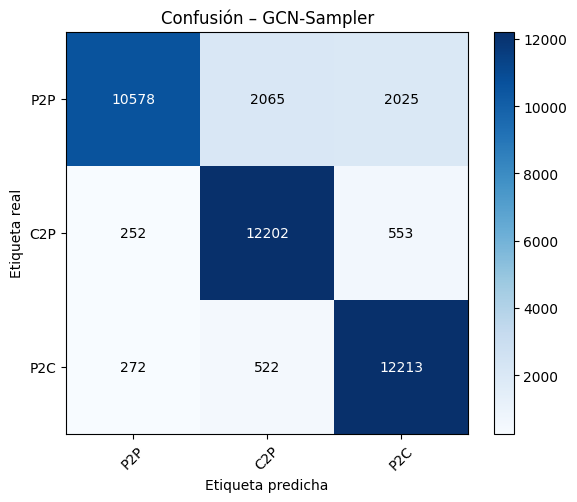

Matriz de confusión normalizada (%)


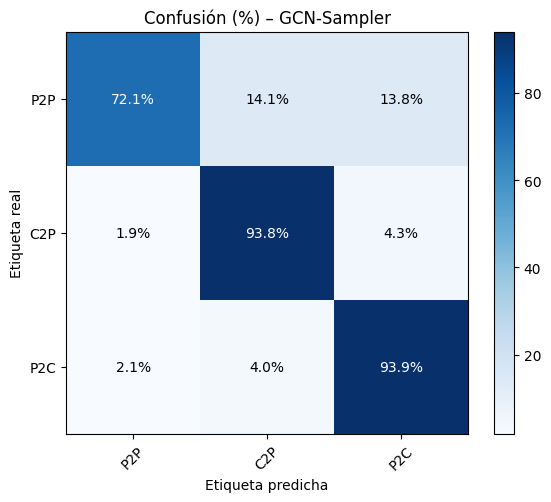

              precision    recall  f1-score   support

           0     0.9528    0.7212    0.8210     14668
           1     0.8251    0.9381    0.8780     13007
           2     0.8257    0.9390    0.8787     13007

    accuracy                         0.8602     40682
   macro avg     0.8679    0.8661    0.8592     40682
weighted avg     0.8713    0.8602    0.8576     40682



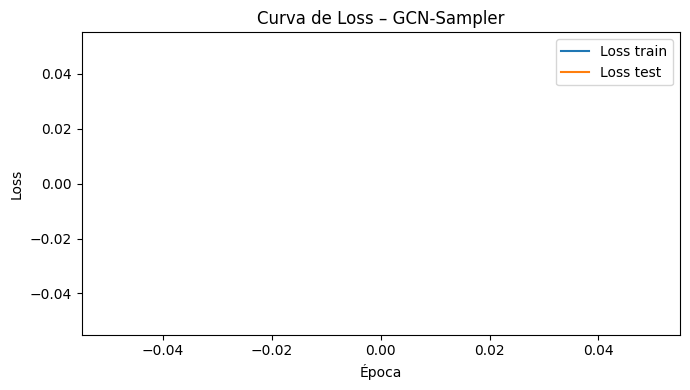

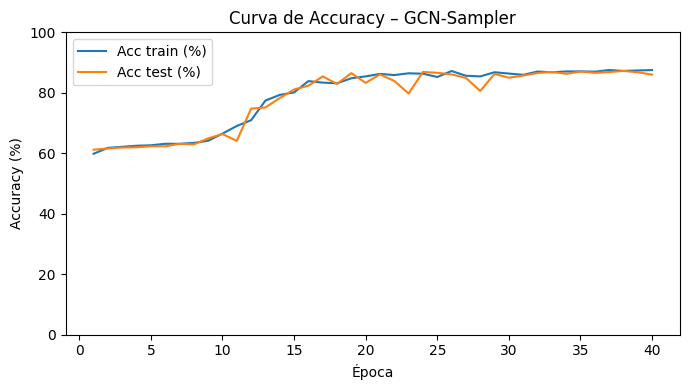


===== Entrenando SAGE-Sampler =====


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 59.91% | loss_te nan acc_te 61.21%


Epoch 002:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 003:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 004:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 005:   0%|          | 0/1000 [00:00<?, ?it/s]

ep005 | loss_tr nan acc_tr 63.13% | loss_te nan acc_te 62.43%


Epoch 006:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 007:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 008:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 009:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 010:   0%|          | 0/1000 [00:00<?, ?it/s]

ep010 | loss_tr nan acc_tr 64.92% | loss_te nan acc_te 67.68%


Epoch 011:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 012:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 013:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 014:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 015:   0%|          | 0/1000 [00:00<?, ?it/s]

ep015 | loss_tr nan acc_tr 80.75% | loss_te nan acc_te 85.66%


Epoch 016:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 017:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 018:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 019:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 020:   0%|          | 0/1000 [00:00<?, ?it/s]

ep020 | loss_tr nan acc_tr 84.25% | loss_te nan acc_te 83.10%


Epoch 021:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 022:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 023:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 024:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 025:   0%|          | 0/1000 [00:00<?, ?it/s]

ep025 | loss_tr nan acc_tr 85.22% | loss_te nan acc_te 84.12%


Epoch 026:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 027:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 028:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 029:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 030:   0%|          | 0/1000 [00:00<?, ?it/s]

ep030 | loss_tr nan acc_tr 86.98% | loss_te nan acc_te 85.58%


Epoch 031:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 032:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 033:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 034:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 035:   0%|          | 0/1000 [00:00<?, ?it/s]

ep035 | loss_tr nan acc_tr 87.44% | loss_te nan acc_te 86.42%


Epoch 036:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 037:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 038:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 039:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 040:   0%|          | 0/1000 [00:00<?, ?it/s]

🛑  Early-stop en época 40
Matriz de confusión sin normalizar


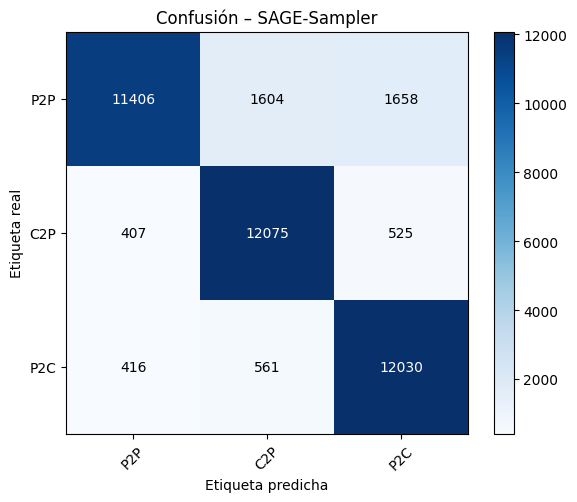

Matriz de confusión normalizada (%)


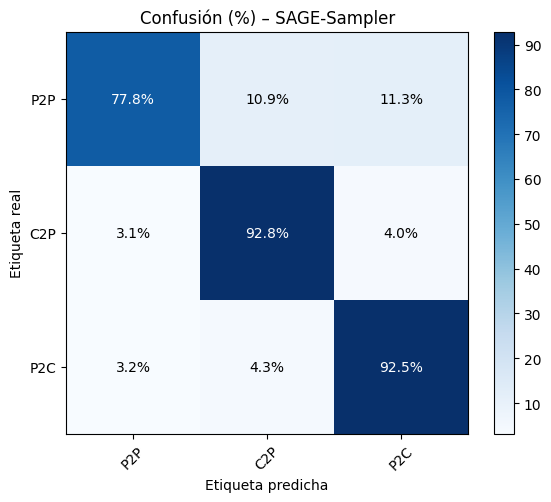

              precision    recall  f1-score   support

           0     0.9327    0.7776    0.8481     14668
           1     0.8480    0.9283    0.8863     13007
           2     0.8464    0.9249    0.8839     13007

    accuracy                         0.8729     40682
   macro avg     0.8757    0.8769    0.8728     40682
weighted avg     0.8780    0.8729    0.8718     40682



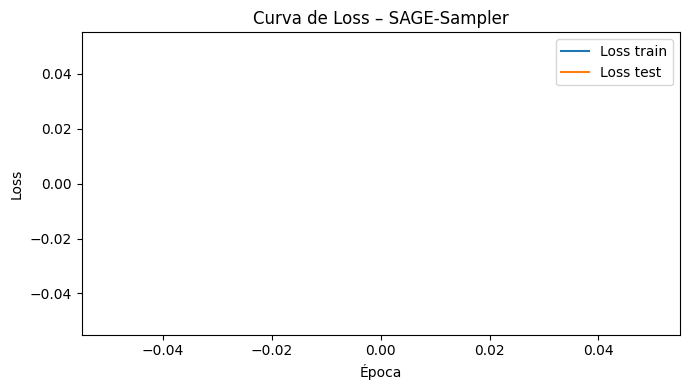

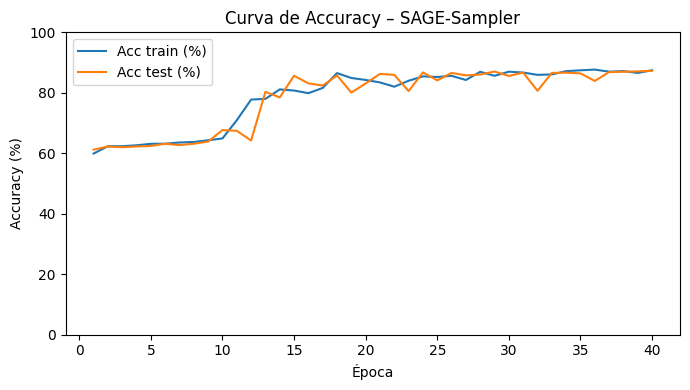


===== Entrenando GAT-Sampler =====


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 45.02% | loss_te nan acc_te 50.03%


Epoch 002:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 003:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 004:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 005:   0%|          | 0/1000 [00:00<?, ?it/s]

ep005 | loss_tr nan acc_tr 51.65% | loss_te nan acc_te 56.03%


Epoch 006:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 007:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 008:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 009:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 010:   0%|          | 0/1000 [00:00<?, ?it/s]

ep010 | loss_tr nan acc_tr 70.90% | loss_te nan acc_te 70.53%


Epoch 011:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 012:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 013:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 014:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 015:   0%|          | 0/1000 [00:00<?, ?it/s]

ep015 | loss_tr nan acc_tr 75.87% | loss_te nan acc_te 76.15%


Epoch 016:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 017:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 018:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 019:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 020:   0%|          | 0/1000 [00:00<?, ?it/s]

ep020 | loss_tr nan acc_tr 75.96% | loss_te nan acc_te 76.46%


Epoch 021:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 022:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 023:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 024:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 025:   0%|          | 0/1000 [00:00<?, ?it/s]

ep025 | loss_tr nan acc_tr 77.48% | loss_te nan acc_te 75.62%


Epoch 026:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 027:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 028:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 029:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 030:   0%|          | 0/1000 [00:00<?, ?it/s]

ep030 | loss_tr nan acc_tr 78.67% | loss_te nan acc_te 77.86%


Epoch 031:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 032:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 033:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 034:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 035:   0%|          | 0/1000 [00:00<?, ?it/s]

ep035 | loss_tr nan acc_tr 79.51% | loss_te nan acc_te 79.05%


Epoch 036:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 037:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 038:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 039:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 040:   0%|          | 0/1000 [00:00<?, ?it/s]

🛑  Early-stop en época 40
Matriz de confusión sin normalizar


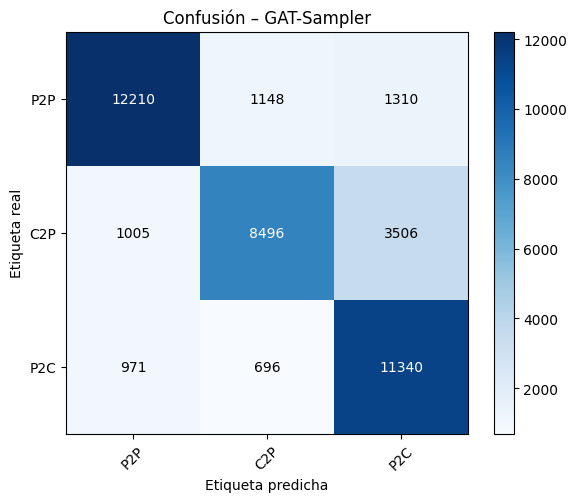

Matriz de confusión normalizada (%)


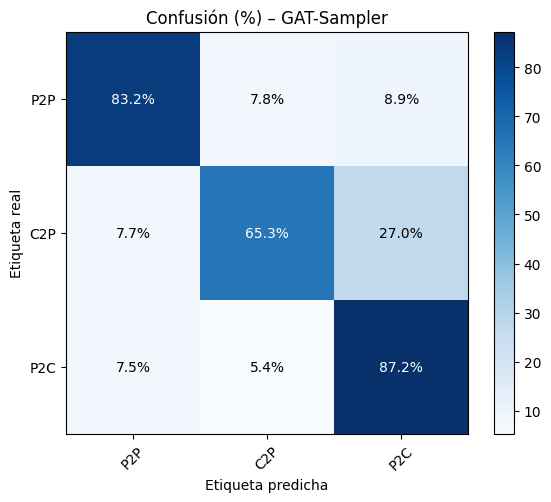

              precision    recall  f1-score   support

           0     0.8607    0.8324    0.8463     14668
           1     0.8217    0.6532    0.7278     13007
           2     0.7019    0.8718    0.7777     13007

    accuracy                         0.7877     40682
   macro avg     0.7948    0.7858    0.7839     40682
weighted avg     0.7975    0.7877    0.7865     40682



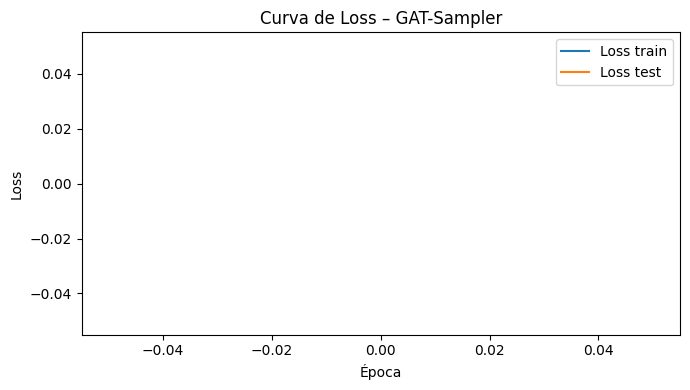

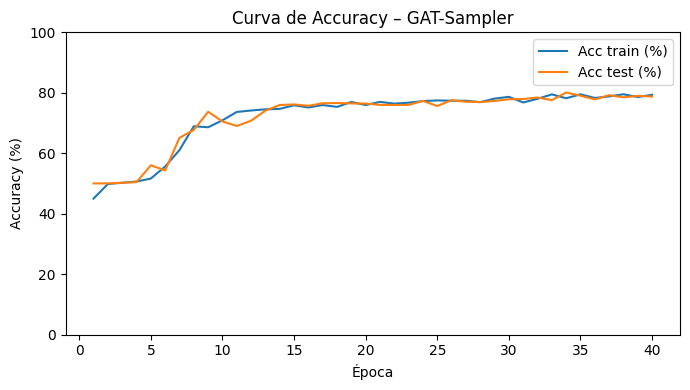

In [ ]:
from tqdm.auto import tqdm
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ─── hiper-parámetros ──────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata['feat'].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
lr        = 1e-3
patience  = 40               # early-stopping
n_classes = 3

# ─── loop sobre modelos ────────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, 64, 32, out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # historial
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0

    for epoch in range(1, NUM_EPOCHS + 1):

        # ── TRAIN ───────────────────────────────────────────────────
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}", leave=False)
        for subg in pbar:                    # subg = grafo de un cluster
            if subg.num_edges() == 0:
                continue 
            subg = subg.to(device)
            x    = subg.ndata['feat'].float()
            y    = subg.edata['Relationship'].long()
            m    = subg.edata['train_mask'].bool()

            h      = model.encode(subg, x)          # <- nota: grafo completo
            logits = model.decodeMLP(subg, h)       # (E_cluster, 3)

            loss = F.cross_entropy(logits[m], y[m])

            optim.zero_grad()
            loss.backward()
            optim.step()

            # métrica batch
            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ── TEST ────────────────────────────────────────────────────
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x    = subg.ndata['feat'].float()
                y    = subg.edata['Relationship'].long()
                m    = subg.edata['test_mask'].bool()

                h      = model.encode(subg, x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred      = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()
                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        # ── historial + early-stopping ─────────────────────────────
        hist['loss_tr'].append(loss_tr);  hist['loss_te'].append(loss_te)
        hist['acc_tr'].append(acc_tr);    hist['acc_te'].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"Early-stop en época {epoch}")
                break

        if epoch % 5 == 0 or epoch == 1:
            print(f"ep{epoch:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final ──────────────────────────────────────────
    if best_state is None:                      # por si nunca mejoró
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    preds = torch.cat(preds_all)
    truth = torch.cat(truth_all)

    cm = confusion_matrix(truth, preds)
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=False, title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=True,  title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds, digits=4))

    # ─── gráficos de historial ─────────────────────────────────────
    ep_axis = range(1, len(hist['loss_tr']) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['loss_tr'], label="Loss train")
    plt.plot(ep_axis, hist['loss_te'], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss")
    plt.title(f"Curva de Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['acc_tr'], label="Acc train (%)")
    plt.plot(ep_axis, hist['acc_te'], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Curva de Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

# 12 min

In [17]:
from collections import Counter
tot = Counter(); tr = Counter(); te = Counter()

for sg in train_loader:             # lo que ve el encoder
    y = sg.edata['Relationship'][ sg.edata['train_mask'] ].tolist()
    tr.update(y)
for sg in test_loader:
    y = sg.edata['Relationship'][ sg.edata['test_mask'] ].tolist()
    te.update(y)

tot.update( gnn.dgl_graph.edata['Relationship'].tolist() )

print("GLOBAL :", tot)
print("TRAIN  :", tr)
print("TEST   :", te)


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


GLOBAL : Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
TRAIN  : Counter({0: 58472, 1: 52588, 2: 52588})
TEST   : Counter({0: 14668, 2: 13007, 1: 13007})


### Caso 4: Se utiliza grafo con atributos de nodos generados aleatoriamente

In [21]:
# CASO 4: Grafo con atributos de nodos generados aleatoriamente 
# ---------------------------------------
INTERNETGRAPH_FILE = DATA_PATH + '/dgl_graph/2024/random'


In [22]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [28]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path= INTERNETGRAPH_FILE,
    index_graph=index_graph,            # grafo de febrero
    caida_path=RELATIONSHIPS_FILE,
    simplify=True, 
)

gnn.add_random_features(dim=64, std=0.05, seed=42, mode="uniform")

# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)

[LOAD DATASET] Leyendo CSV …
Done loading data from cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(69,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] Simplificando  …
[LOAD DATASET] Etiquetando CAIDA → /media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:00, 518095.93it/s]


[CAIDA] Añadidas 977494 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411, -1: 149377})
[add_random_features] feat ← (401308, 64)  |  mode=uniform
[split] train=782042  test=195512
  clases train: {1: 123677, 0: 534688, 2: 123677}


In [ ]:
# RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

# gnn = GNN(debug=True)

# # Cargo dataset y etiqueto sgun archivo de relaciones
# gnn.load_dataset(
#     data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
#     force_reload=True,
#     index_graph = 1,  # Indice del grafo a cargar febrero
#     simplify=True,            # ⇐ hazlo sólo una vez
#     caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
# )


# # 64 features con poca varianza inicial
# # gnn.add_random_features(dim=64, std=0.05, seed=42, mode="minmax")

# # gnn.add_random_features(dim=64, std=0.05, seed=42, mode="zscore")

# gnn.add_random_features(dim=64, std=0.05, seed=42, mode="uniform")


# # crea máscaras + devuelve eids
# train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)


 Training GCN 
 ---------------
ep01 | loss_tr 0.9181 acc_tr 68.37% | loss_te 0.8128 acc_te 68.56%
ep10 | loss_tr 0.5809 acc_tr 71.54% | loss_te 0.5792 acc_te 72.15%
ep20 | loss_tr 0.5576 acc_tr 72.72% | loss_te 0.5464 acc_te 71.93%
ep30 | loss_tr 0.5262 acc_tr 74.40% | loss_te 0.5202 acc_te 74.24%
ep40 | loss_tr 0.5085 acc_tr 76.74% | loss_te 0.4934 acc_te 78.88%
ep50 | loss_tr 0.4872 acc_tr 78.42% | loss_te 0.5153 acc_te 80.07%
ep60 | loss_tr 0.4617 acc_tr 84.11% | loss_te 0.4459 acc_te 85.41%
ep70 | loss_tr 0.4103 acc_tr 87.83% | loss_te 0.4105 acc_te 87.23%
🛑  Early stop en época 79
Matriz de confusión sin normalizar


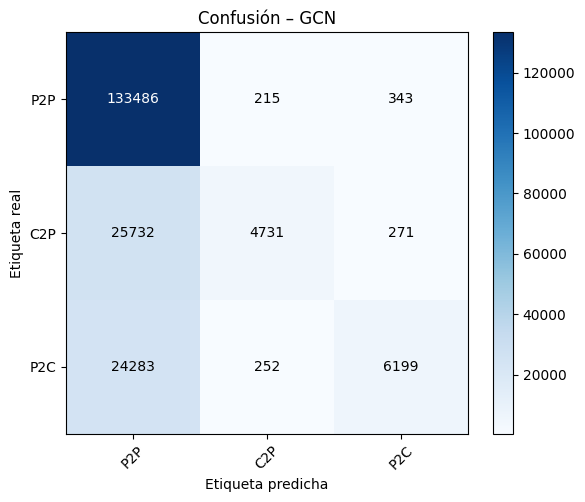

Matriz de confusión normalizada (%)


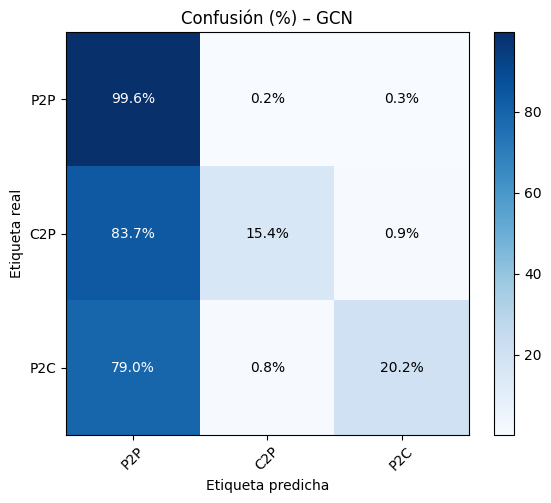

              precision    recall  f1-score   support

           0     0.7274    0.9958    0.8407    134044
           1     0.9102    0.1539    0.2633     30734
           2     0.9099    0.2017    0.3302     30734

    accuracy                         0.7387    195512
   macro avg     0.8492    0.4505    0.4781    195512
weighted avg     0.7848    0.7387    0.6697    195512



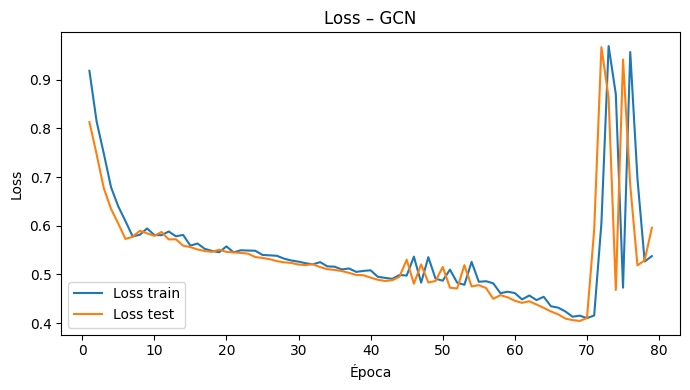

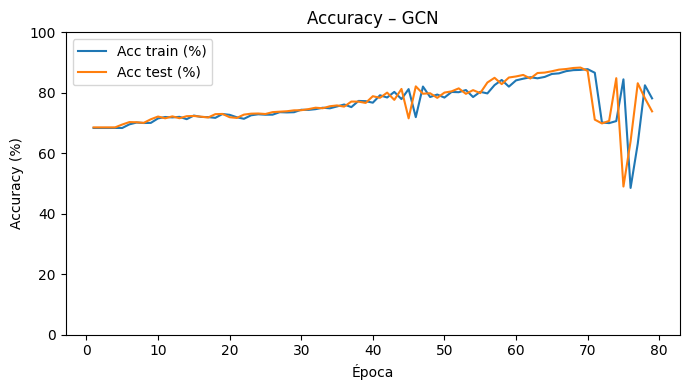


 Training GraphSAGE 
 ---------------
ep01 | loss_tr 1.4307 acc_tr 15.14% | loss_te 1.1792 acc_te 15.72%
ep10 | loss_tr 0.8954 acc_tr 68.42% | loss_te 0.8553 acc_te 68.56%
ep20 | loss_tr 0.8413 acc_tr 68.38% | loss_te 0.8373 acc_te 68.56%
🛑  Early stop en época 21
Matriz de confusión sin normalizar


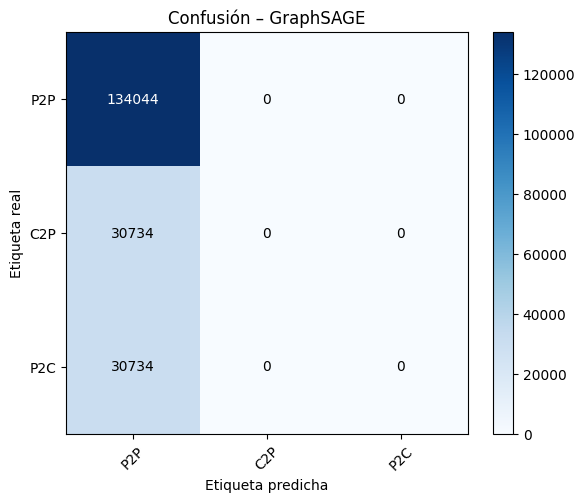

Matriz de confusión normalizada (%)


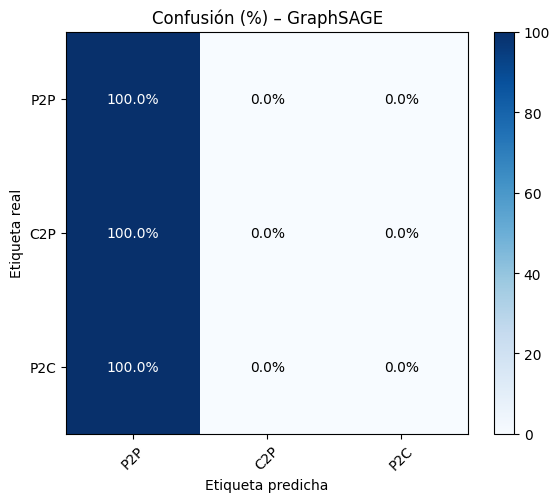

              precision    recall  f1-score   support

           0     0.6856    1.0000    0.8135    134044
           1     0.0000    0.0000    0.0000     30734
           2     0.0000    0.0000    0.0000     30734

    accuracy                         0.6856    195512
   macro avg     0.2285    0.3333    0.2712    195512
weighted avg     0.4701    0.6856    0.5577    195512



/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

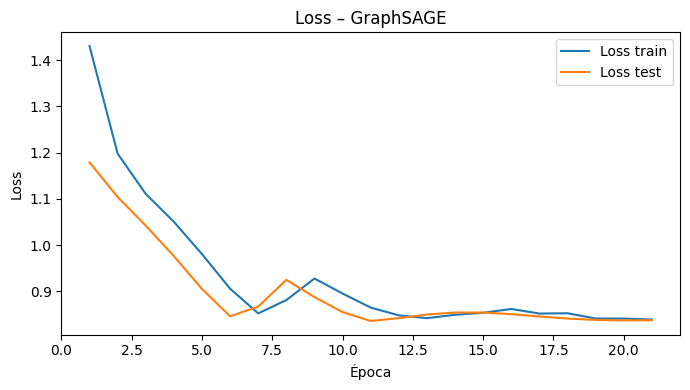

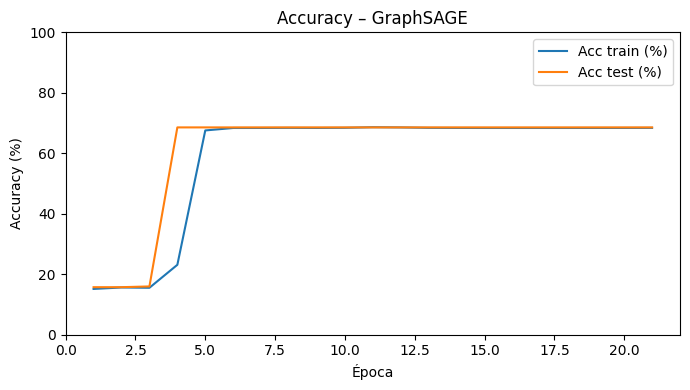


 Training GAT 
 ---------------
ep01 | loss_tr 1.2594 acc_tr 15.55% | loss_te 0.8839 acc_te 68.56%
ep10 | loss_tr 0.8548 acc_tr 68.37% | loss_te 0.8576 acc_te 68.56%
ep20 | loss_tr 0.8080 acc_tr 68.37% | loss_te 0.8146 acc_te 68.56%
ep30 | loss_tr 0.6687 acc_tr 72.89% | loss_te 0.7180 acc_te 68.74%
ep40 | loss_tr 0.4583 acc_tr 84.22% | loss_te 0.5703 acc_te 78.85%
ep50 | loss_tr 0.4151 acc_tr 86.96% | loss_te 0.5472 acc_te 79.64%
ep60 | loss_tr 0.4109 acc_tr 86.78% | loss_te 0.5459 acc_te 84.44%
🛑  Early stop en época 65
Matriz de confusión sin normalizar


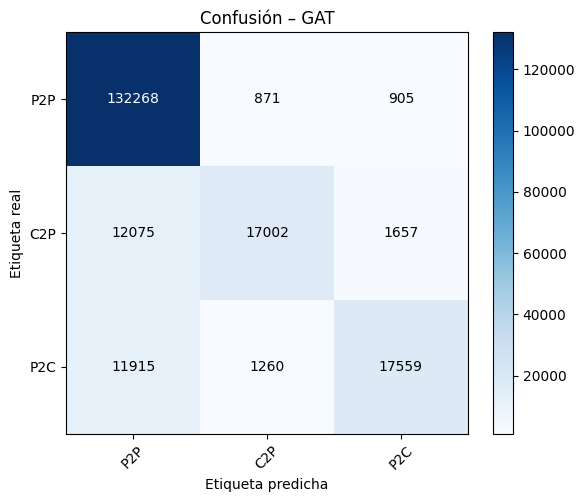

Matriz de confusión normalizada (%)


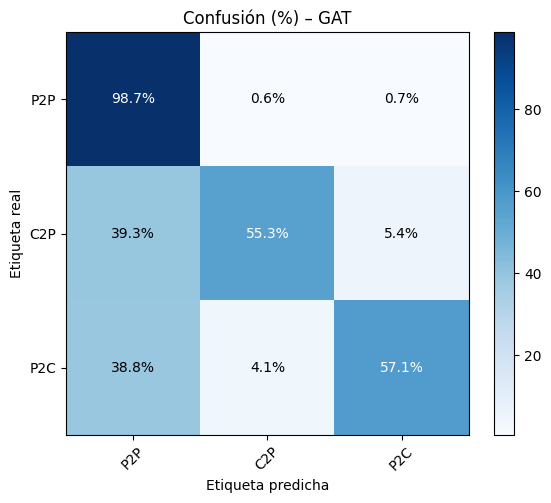

              precision    recall  f1-score   support

           0     0.8465    0.9868    0.9112    134044
           1     0.8886    0.5532    0.6819     30734
           2     0.8727    0.5713    0.6906     30734

    accuracy                         0.8533    195512
   macro avg     0.8693    0.7038    0.7612    195512
weighted avg     0.8572    0.8533    0.8405    195512



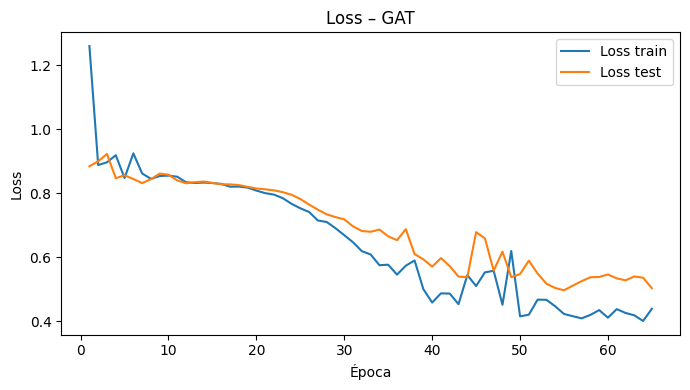

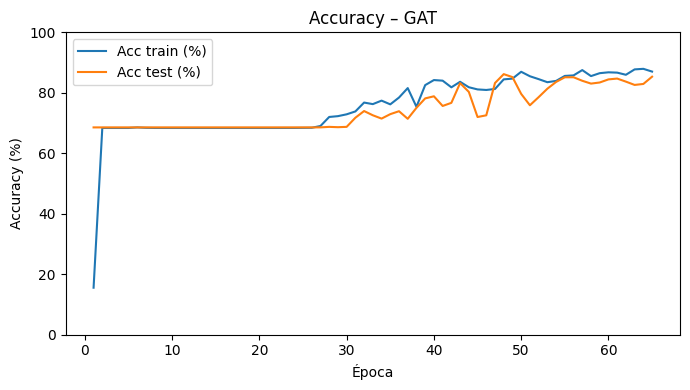

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Parámetros 
# ------------------------------------------
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
lr        = 0.01
patience  = 10           # early-stopping
n_classes = 3

# Datos y máscaras 
# ------------------------------------------
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n Training {name} \n ---------------")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, NUM_EPOCHS + 1):
        # Entrenamiento 
        # ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        # loss   = F.cross_entropy(logits[train_m], labels[train_m], weight=class_weights)

        
        opt.zero_grad() 
        loss.backward()
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            # loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m], weight=class_weights)
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

# 5 min